In [ ]:
import pandas as pd
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt

import ray

import functions
from analyst import Analyst

### DATA CLEANING

In [ ]:
data = pd.read_csv('data.csv', index_col='Date')
data = functions.clean_data(data=data, anomalous_ret=0.1, plot=True, verbose=True)
data.index = pd.DatetimeIndex(data.index).round('1D')

In [221]:
data

USDEUR    USDGBP      USDJPY    USDAUD    USDNZD   USDCAD  \
Date                                                                      
2006-05-16  1.285000  1.887398  109.760002  0.767106  0.626017  1.10700   
2006-05-17  1.274194  1.882495  110.910004  0.759417  0.623014  1.11510   
2006-05-18  1.285099  1.893294  110.900002  0.764000  0.622200  1.11960   
2006-05-19  1.276699  1.880017  111.660004  0.757174  0.621891  1.11740   
2006-05-22  1.285298  1.885085  111.459999  0.753409  0.623014  1.11670   
...              ...       ...         ...       ...       ...      ...   
2023-04-04  1.091227  1.242313  132.298996  0.678850  0.630271  1.34337   
2023-04-05  1.096011  1.249844  131.485001  0.675808  0.631528  1.34380   
2023-04-06  1.090334  1.246308  130.934006  0.671668  0.631852  1.34543   
2023-04-07  1.092013  1.243900  131.669006  0.667601  0.624571  1.34950   
2023-04-08  1.092013  1.243900  131.669006  0.667111  0.624571  1.35070   

              USDNOK    USDSEK   USDCHF    EURGBP  ...    NZDCAD    NZDNOK  \
Date                                               ...                       
2006-05-16   6.10050   7.31770  1.20780  2.425307  ...  0.693001  3.819018   
2006-05-17   6.13040   7.38820  1.21450  2.398663  ...  0.694723  3.819326   
2006-05-18   6.07390   7.28540  1.20500  2.433071  ...  0.696615  3.779181   
2006-05-19   6.10600   7.32030  1.21750  2.400216  ...  0.694901  3.797264   
2006-05-22   6.07940   7.26650  1.20530  2.422895  ...  0.695720  3.787552   
...              ...       ...      ...       ...  ...       ...       ...   
2023-04-04  10.27500  10.36340  0.91271  1.355645  ...  0.846687  6.476031   
2023-04-05  10.30150  10.27060  0.90540  1.369842  ...  0.848648  6.505690   
2023-04-06  10.44984  10.41086  0.90636  1.358892  ...  0.850112  6.602749   
2023-04-07  10.44107  10.42112  0.90440  1.358355  ...  0.842858  6.521185   
2023-04-08  10.44107  10.42112  0.90510  1.358355  ...  0.842858  6.521185   

              NZDSEK    NZDCHF     CADNOK     CADSEK    CADCHF      NOKSEK  \
Date                                                                         
2006-05-16  4.581007  0.756104   6.753254   8.100694  1.337035   44.641629   
2006-05-17  4.602953  0.756651   6.836009   8.238582  1.354289   45.292621   
2006-05-18  4.532976  0.749751   6.800339   8.156734  1.349118   44.250792   
2006-05-19  4.552425  0.757152   6.822845   8.179704  1.360435   44.697752   
2006-05-22  4.527132  0.750919   6.788866   8.114501  1.345959   44.175961   
...              ...       ...        ...        ...       ...         ...   
2023-04-04  6.531747  0.575254  13.803126  13.921881  1.226107  106.483936   
2023-04-05  6.486176  0.571786  13.843156  13.801632  1.216676  105.802592   
2023-04-06  6.578119  0.572685  14.059528  14.007084  1.219444  108.791818   
2023-04-07  6.508725  0.564862  14.090223  14.063300  1.220488  108.807636   
2023-04-08  6.508725  0.564862  14.090223  14.063300  1.222519  108.807636   

              NOKCHF    SEKCHF  
Date                            
2006-05-16  7.368184  8.838318  
2006-05-17  7.445371  8.972968  
2006-05-18  7.319050  8.778907  
2006-05-19  7.434055  8.912465  
2006-05-22  7.327501  8.758312  
...              ...       ...  
2023-04-04  9.378095  9.458779  
2023-04-05  9.326978  9.299001  
2023-04-06  9.471316  9.435987  
2023-04-07  9.442903  9.424861  
2023-04-08  9.442903  9.424861  

[4400 rows x 45 columns]

### PAIR SELECTION

1. Normalizziamo i prezzi (i.e. cum_rets not compounded)
2. Calcoliamo la Tracking-Variance(TV)
3. Calcoliamo il test di cointegrazione di Engle-Granger (sia ccy_1 vs ccy_2 che ccy_2 vs ccy_1, ne prendiamo il minimo)
4. Teniamo solo le coppie che superano il test di EG
5. Delle residue coppie teniamo solo quelle che hanno una TV che si colloca nel x% percentile delle più basse (pre-selezione di EG)
6. Prendo le N coppie che hanno TV più bassa e che hanno superato sia il punto 4) che il punto 5)

2023-04-11 19:27:40,746	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=30552) 4| Computing: MMM|ATVI
(calc_x pid=33948) 3| Computing: MMM|ACN
(calc_x pid=30584) 5| Computing: MMM|ADM
(calc_x pid=33300) 1| Computing: MMM|ABT
(calc_x pid=26656) 2| Computing: MMM|ABBV
(calc_x pid=16020) 0| Computing: MMM|AOS
(calc_x pid=21460) 7| Computing: MMM|ADP
(calc_x pid=2844) 6| Computing: MMM|ADBE
(calc_x pid=30552) 14| Computing: MMM|ALK
(calc_x pid=33948) 9| Computing: MMM|AES
(calc_x pid=30584) 12| Computing: MMM|APD
(calc_x pid=33300) 8| Computing: MMM|AAP
(calc_x pid=26656) 13| Computing: MMM|AKAM
(calc_x pid=16020) 10| Computing: MMM|AFL
(calc_x pid=21460) 15| Computing: MMM|ALB
(calc_x pid=2844) 11| Computing: MMM|A
(calc_x pid=33948) 16| Computing: MMM|ARE
(calc_x pid=30584) 19| Computing: MMM|ALL
(calc_x pid=33300) 18| Computing: MMM|LNT
(calc_x pid=26656) 21| Computing: MMM|GOOG
(calc_x pid=16020) 20| Computing: MMM|GOOGL
(calc_x pid=21460) 22| Computing: MMM|MO
(calc_x pid=2844) 17| Computing: MMM|ALGN
(calc_x pid=30552) 23| Computing: MMM|AMZN

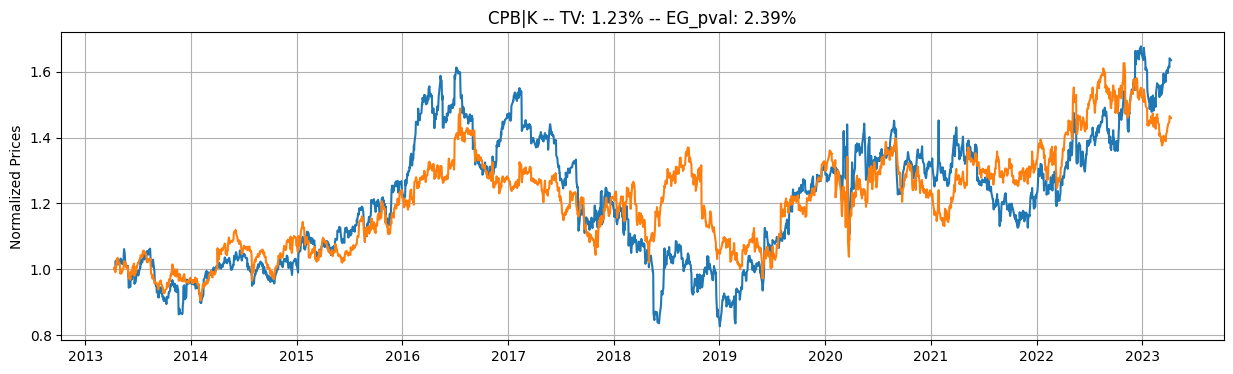

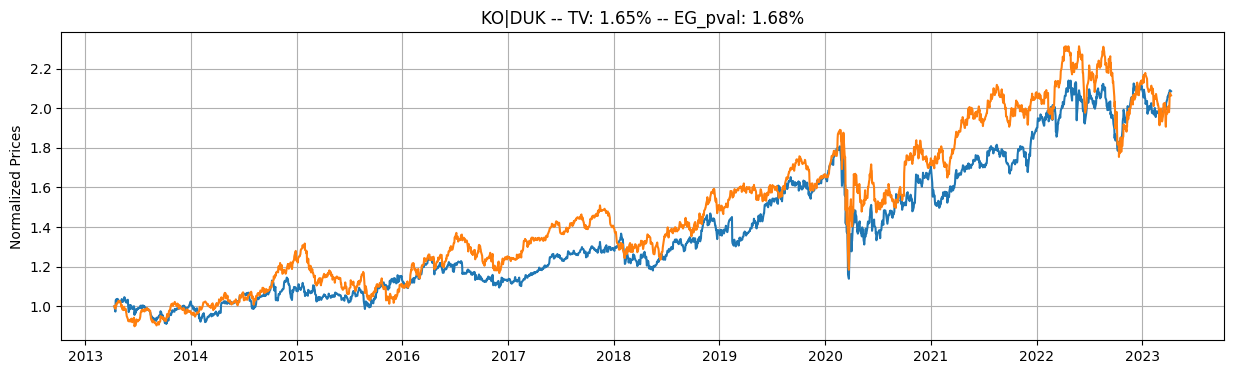

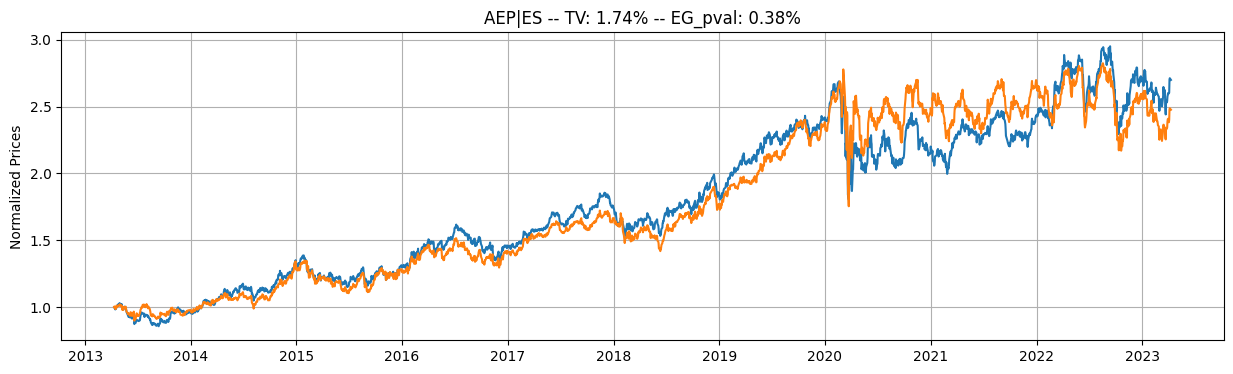

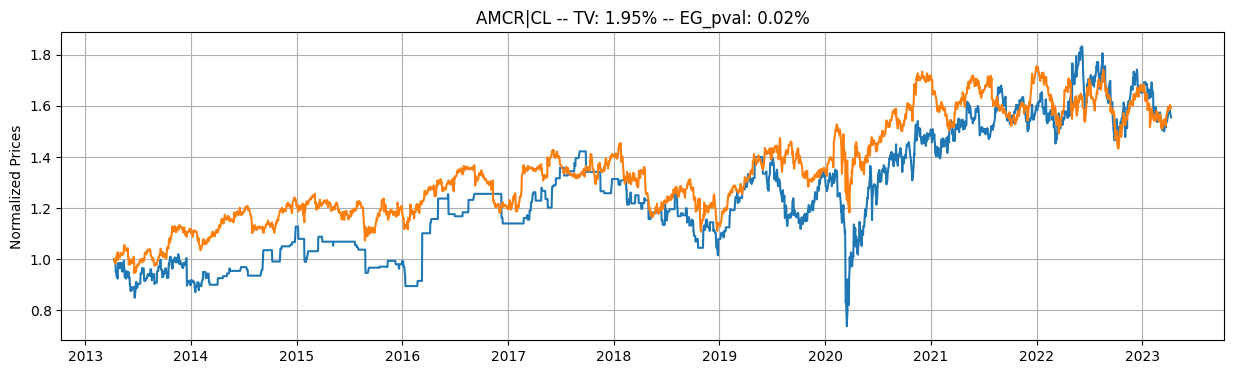

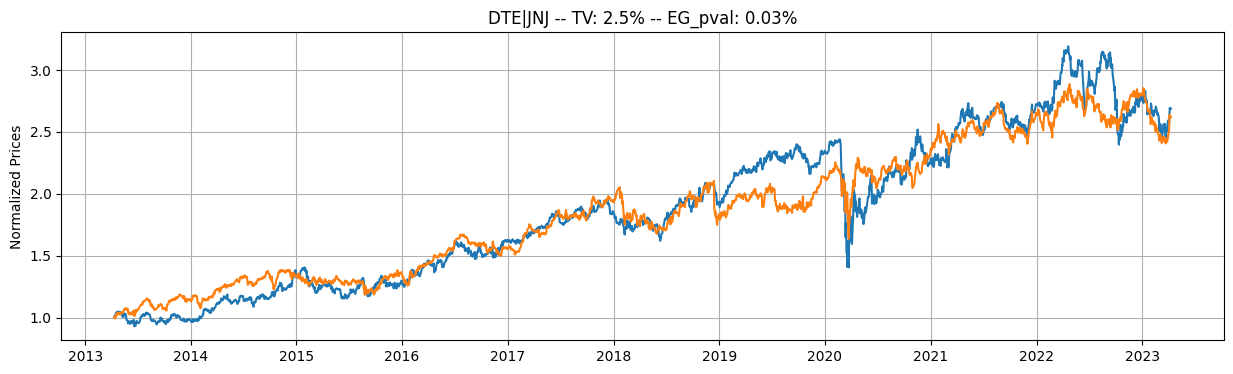

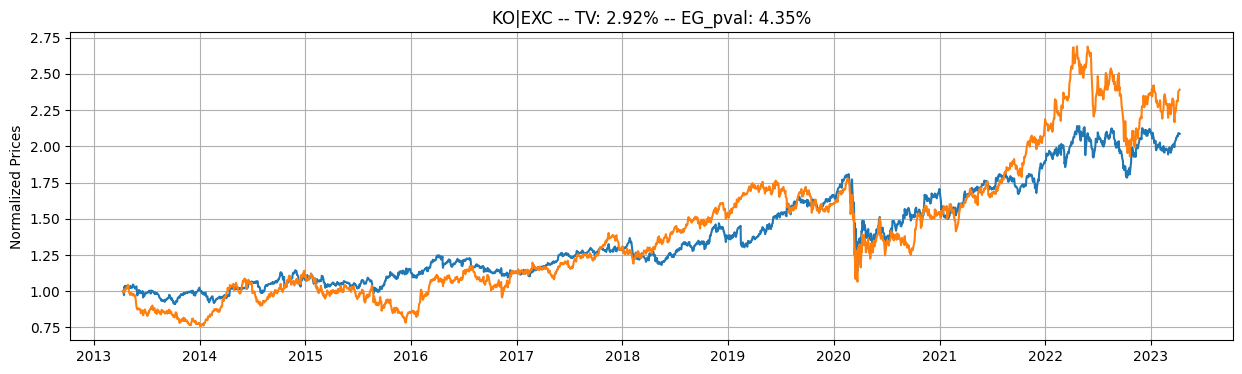

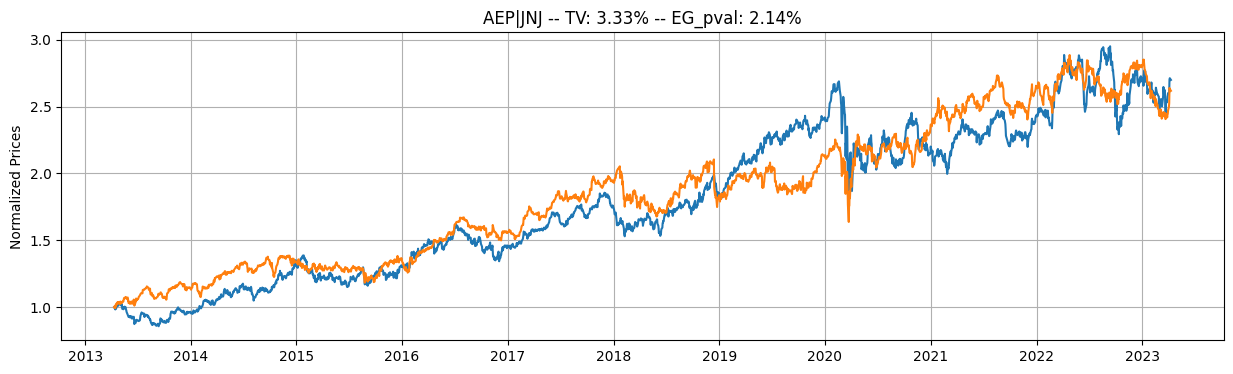

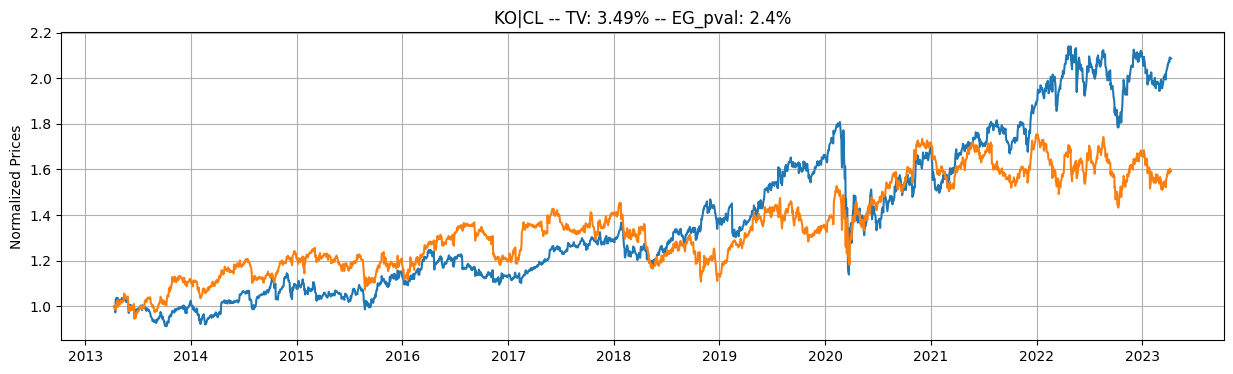

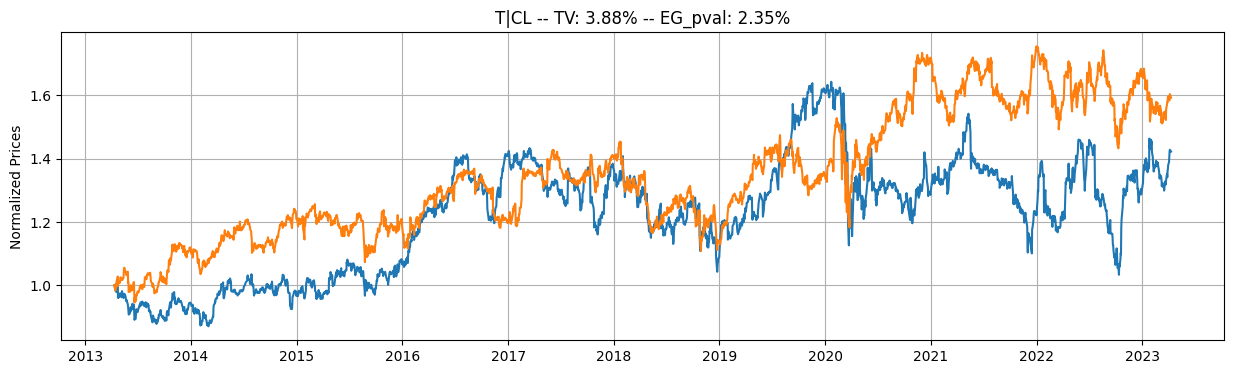

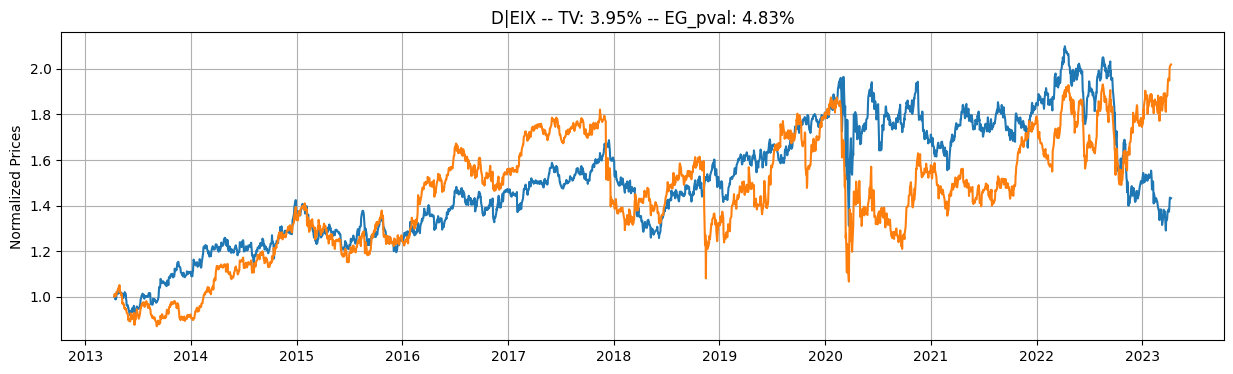

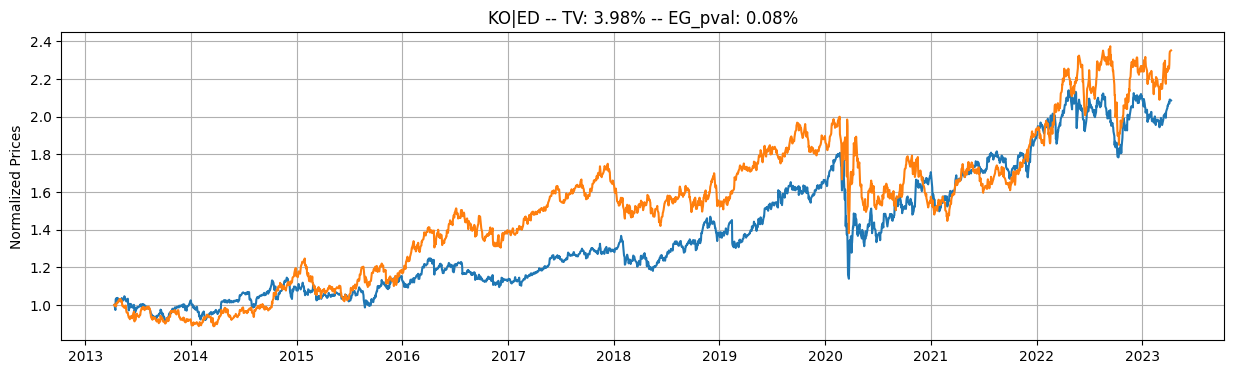

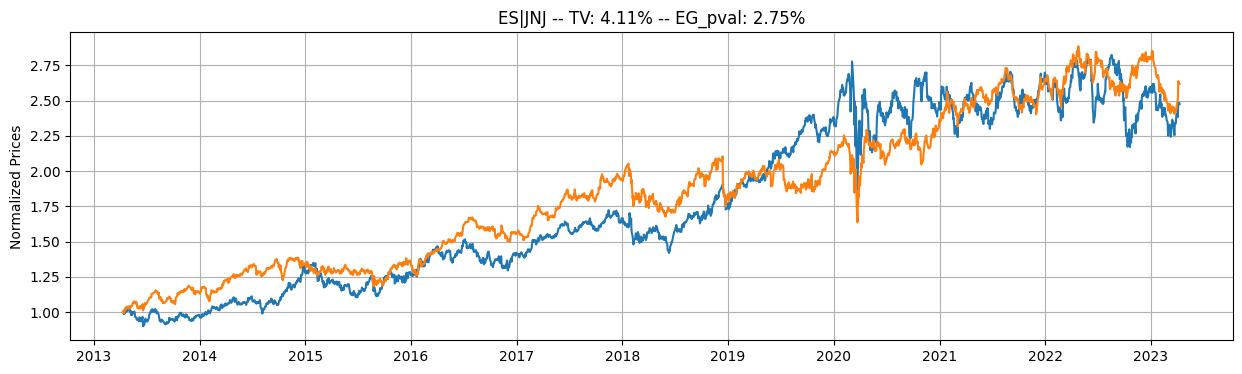

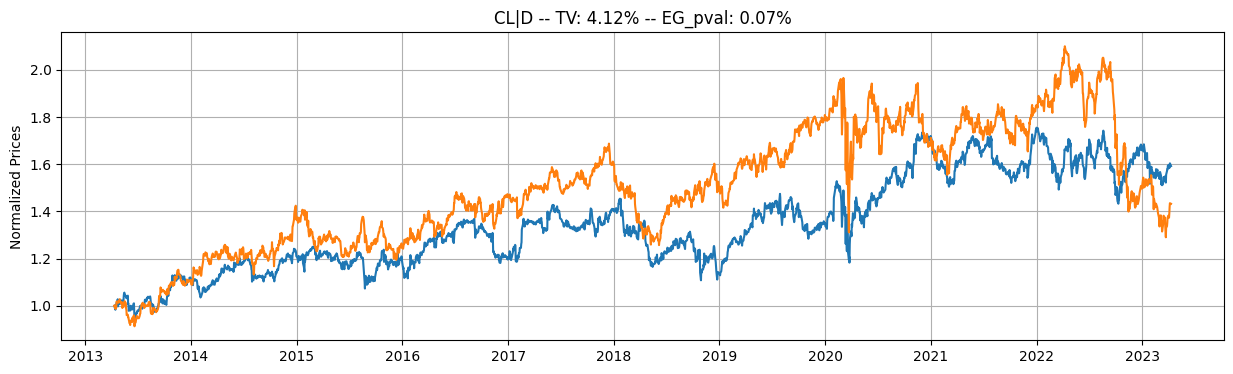

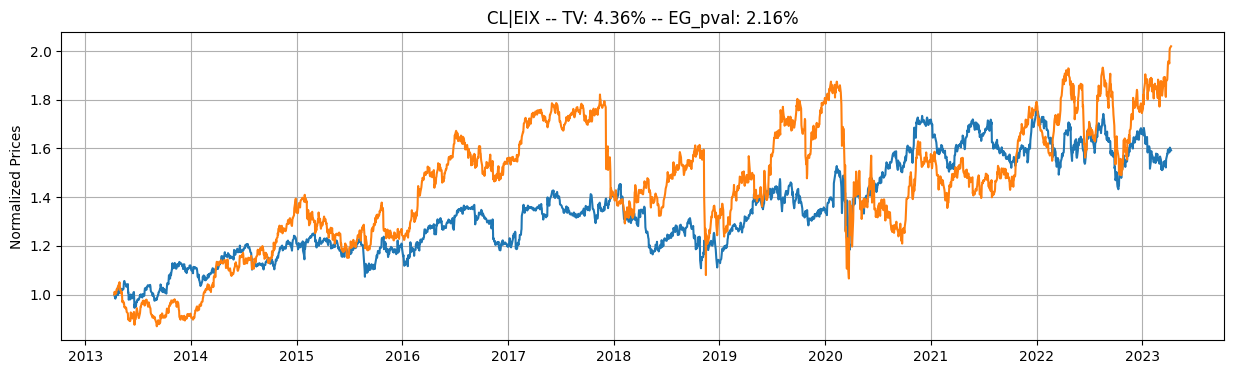

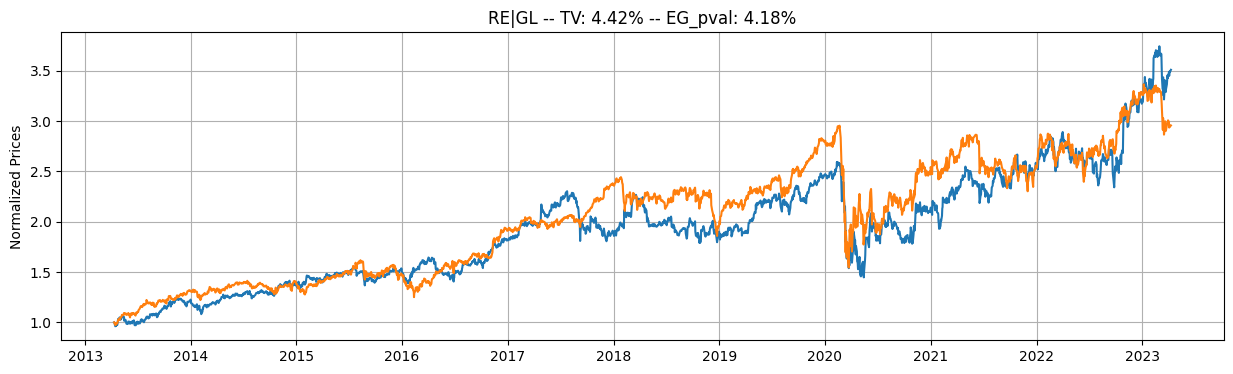

In [413]:
ray.shutdown()

top_pairs = functions.find_best_assets_for_pair_trading(
    price_df=data.iloc[:int(len(data) / 2)],
    tv_quantile_threshold=0.10,
    coint_threshold=0.05,
    top_n_assets=15,
    verbose=True
)

for idx, info in top_pairs.iterrows():
    ccy_1, ccy_2 = idx.split("|")
    norm_prices = data[[ccy_1, ccy_2]].div(data[[ccy_1, ccy_2]].iloc[0])

    plt.figure(figsize=(15, 4))
    plt.plot(norm_prices)
    plt.title(f"{idx} -- TV: {round(info['tv'] * 100, 2)}% -- EG_pval: {round(info['eg_coint_pval'] * 100, 2)}%")
    plt.ylabel('Normalized Prices')
    plt.grid()
    plt.show()


### BACKTEST

- Ho un capitale fisso (e.g. $ 1M)
- Lo alloco in modo equiponderato agli N assets selezionati

- Come uso il capitale che, ipoteticamente, non viene investito per assenza di co-integrazione?
    1. Cash (short-term bond)              (riskless)
    2. Pair-trading sugli indici sintetici (riskier)
    3. Lo tengo da parte per poter fare hedgin quando ci sono condizioni di stress

- ^SPX: No data found for this date range, symbol may be delisted


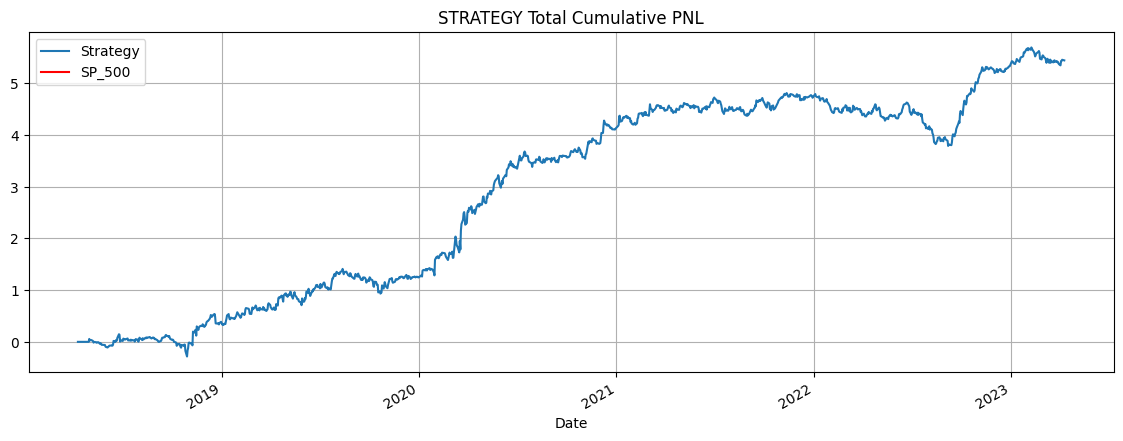

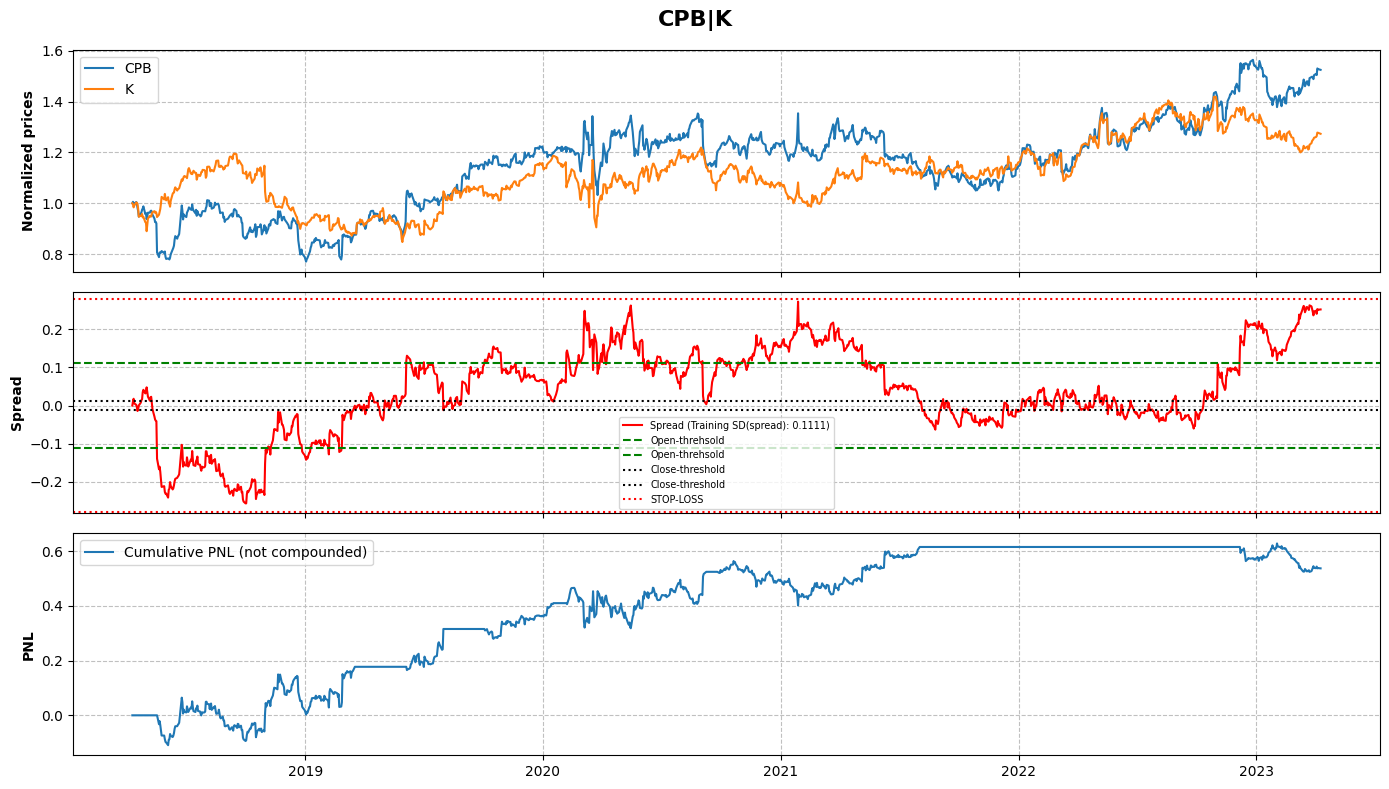

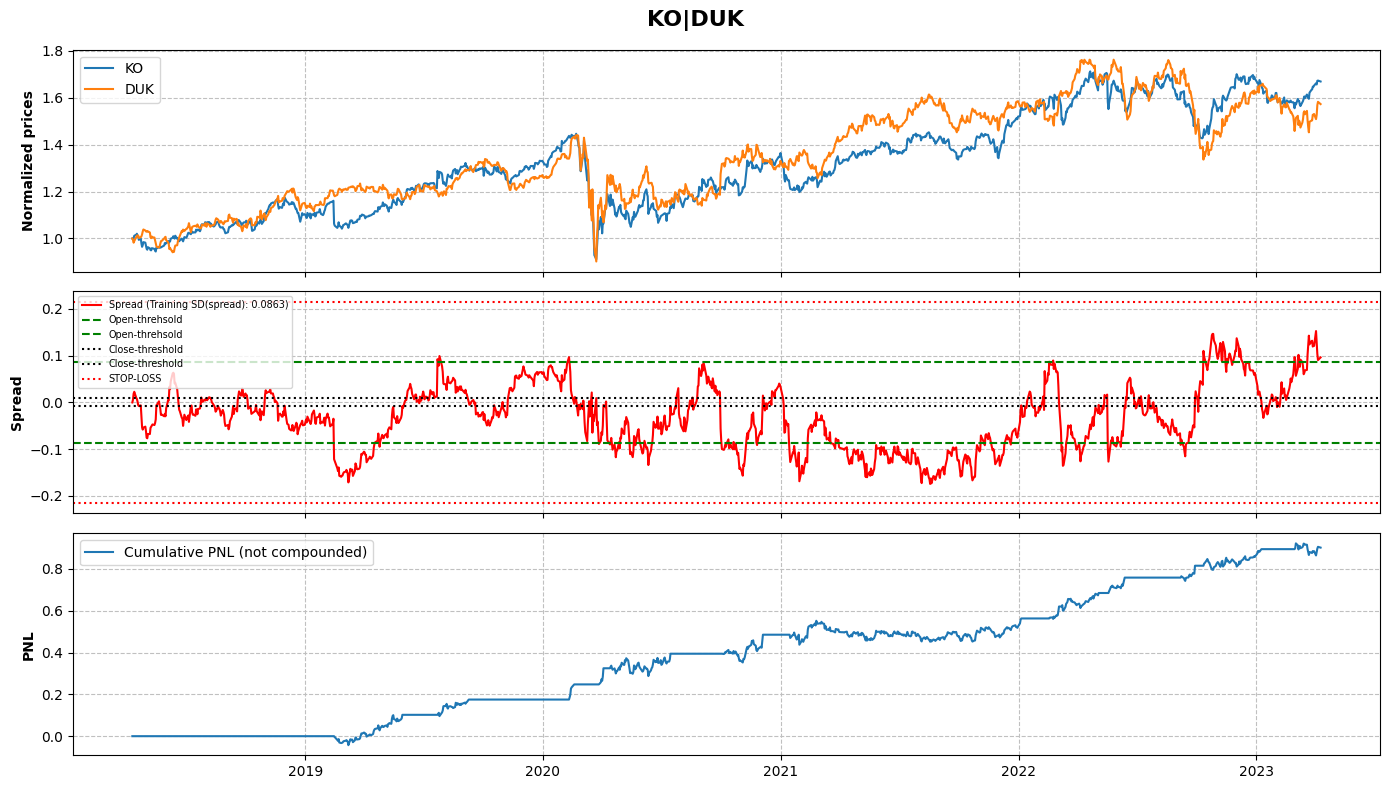

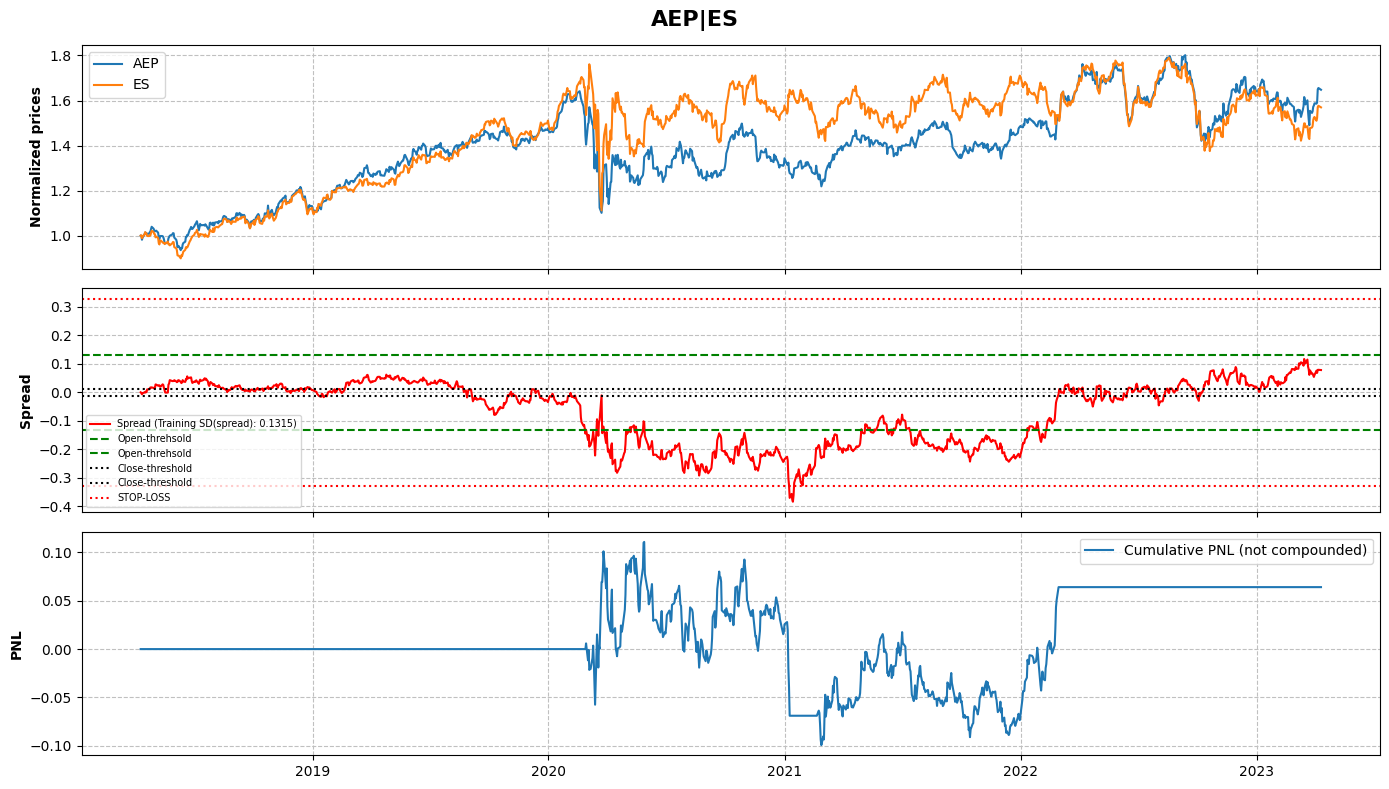

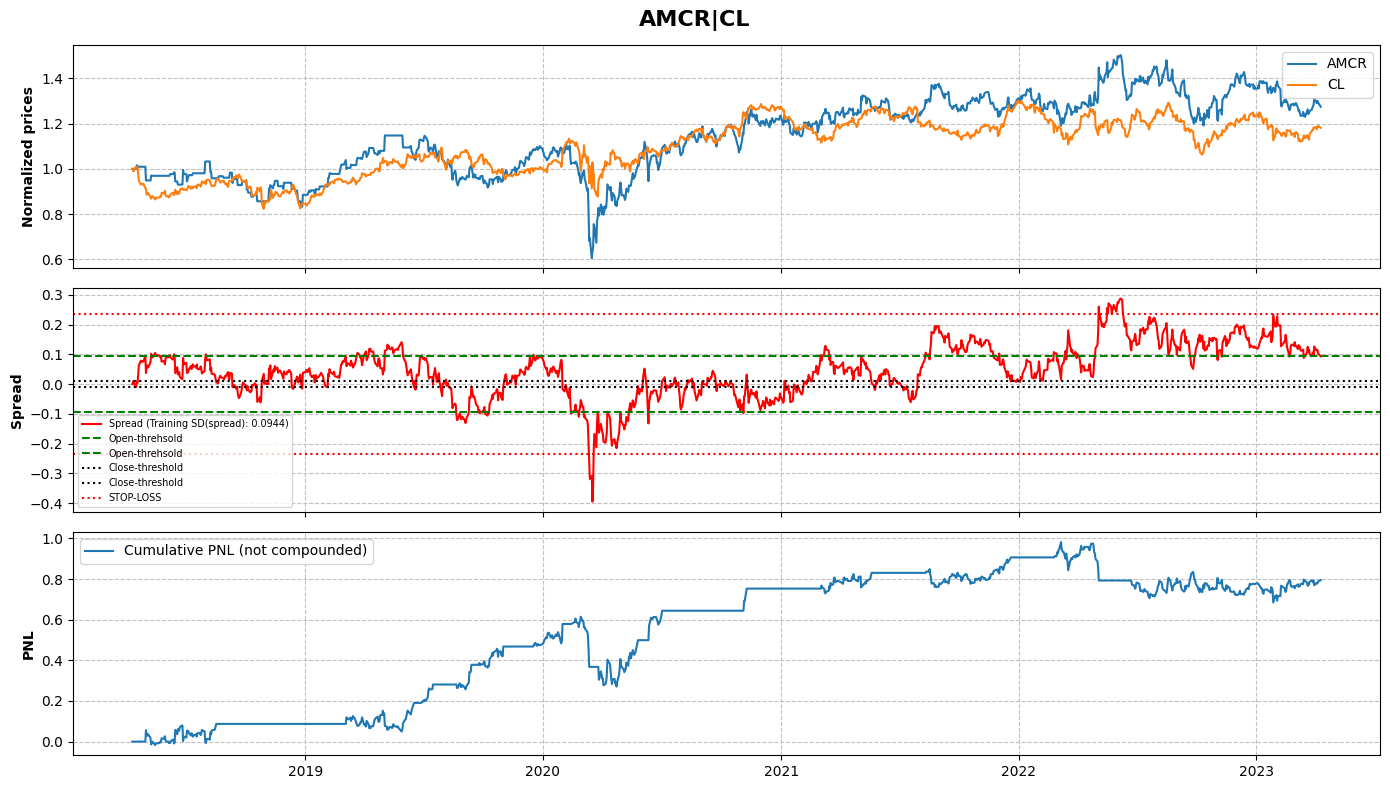

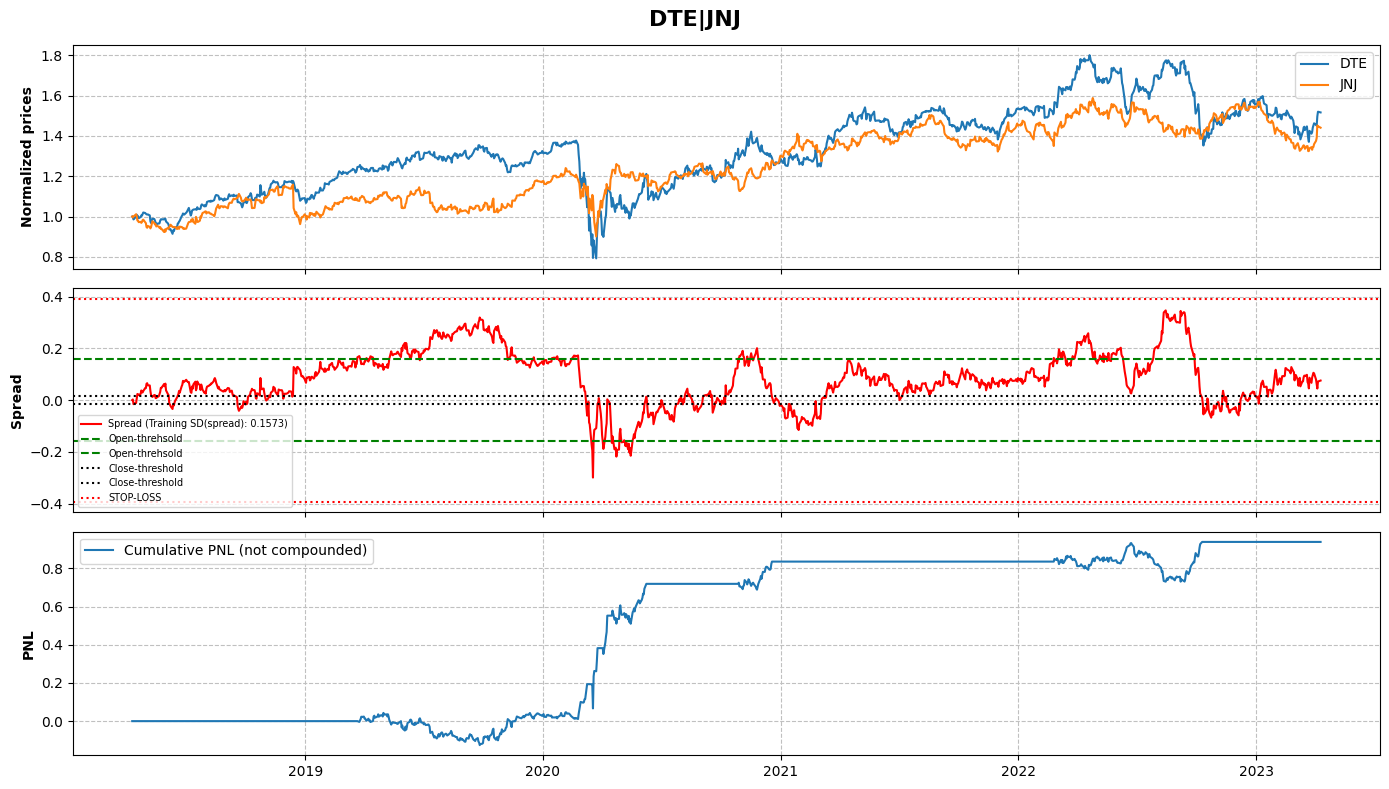

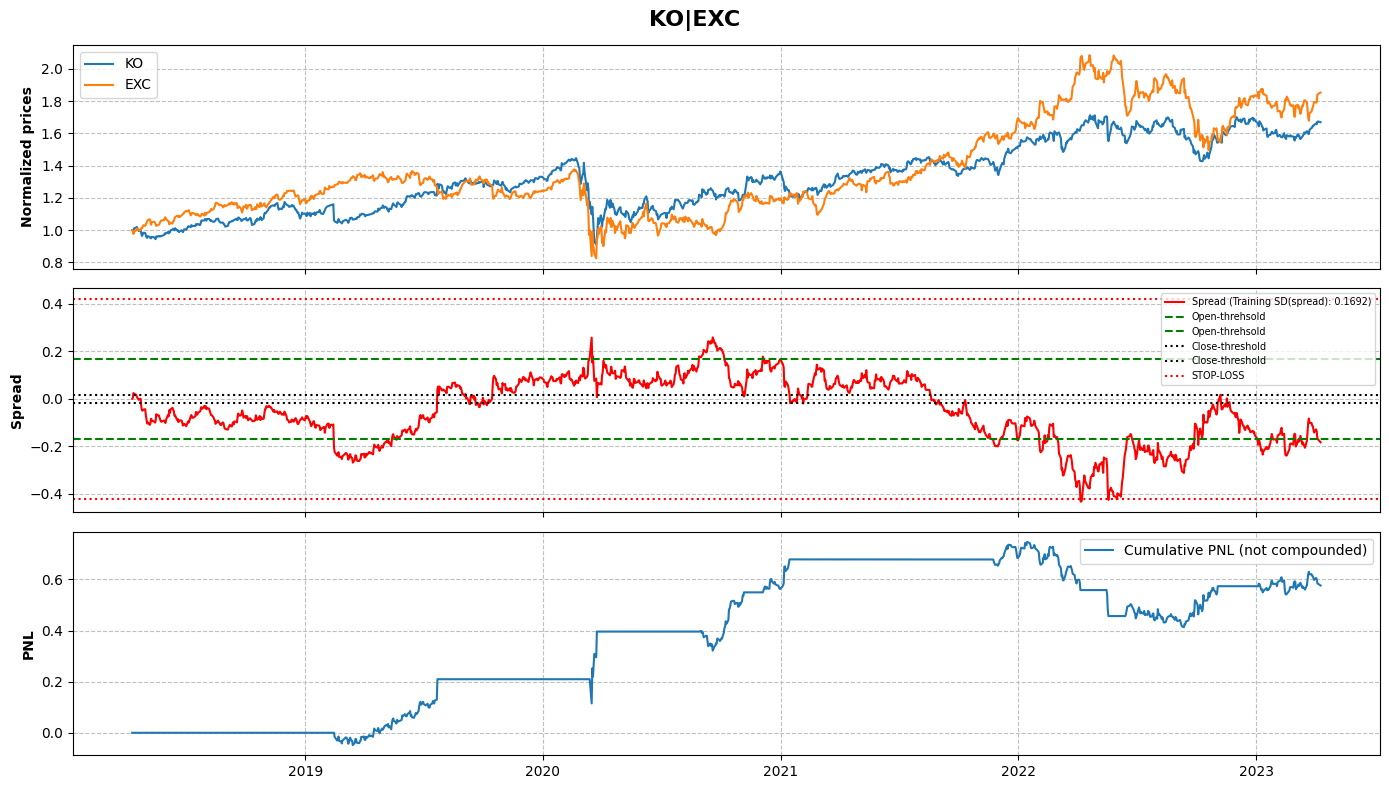

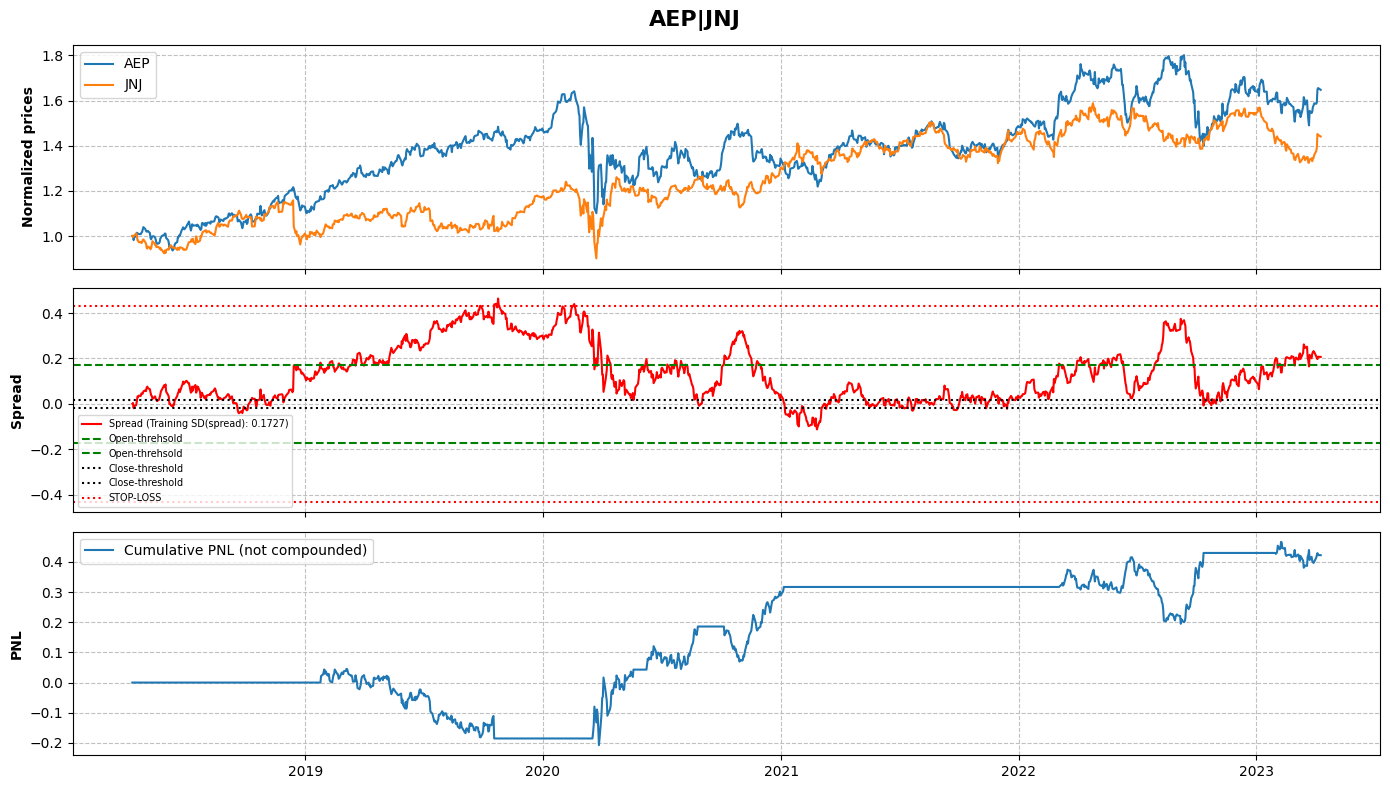

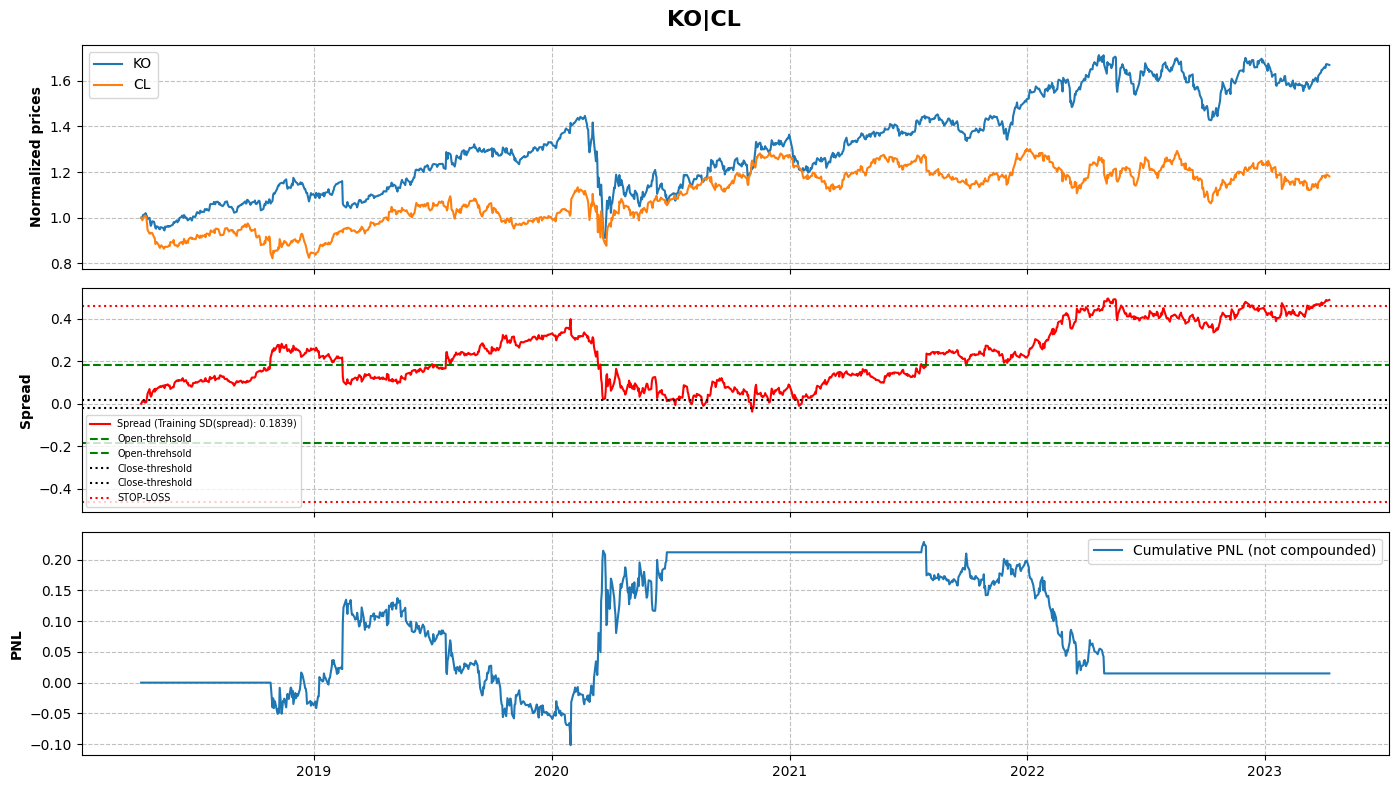

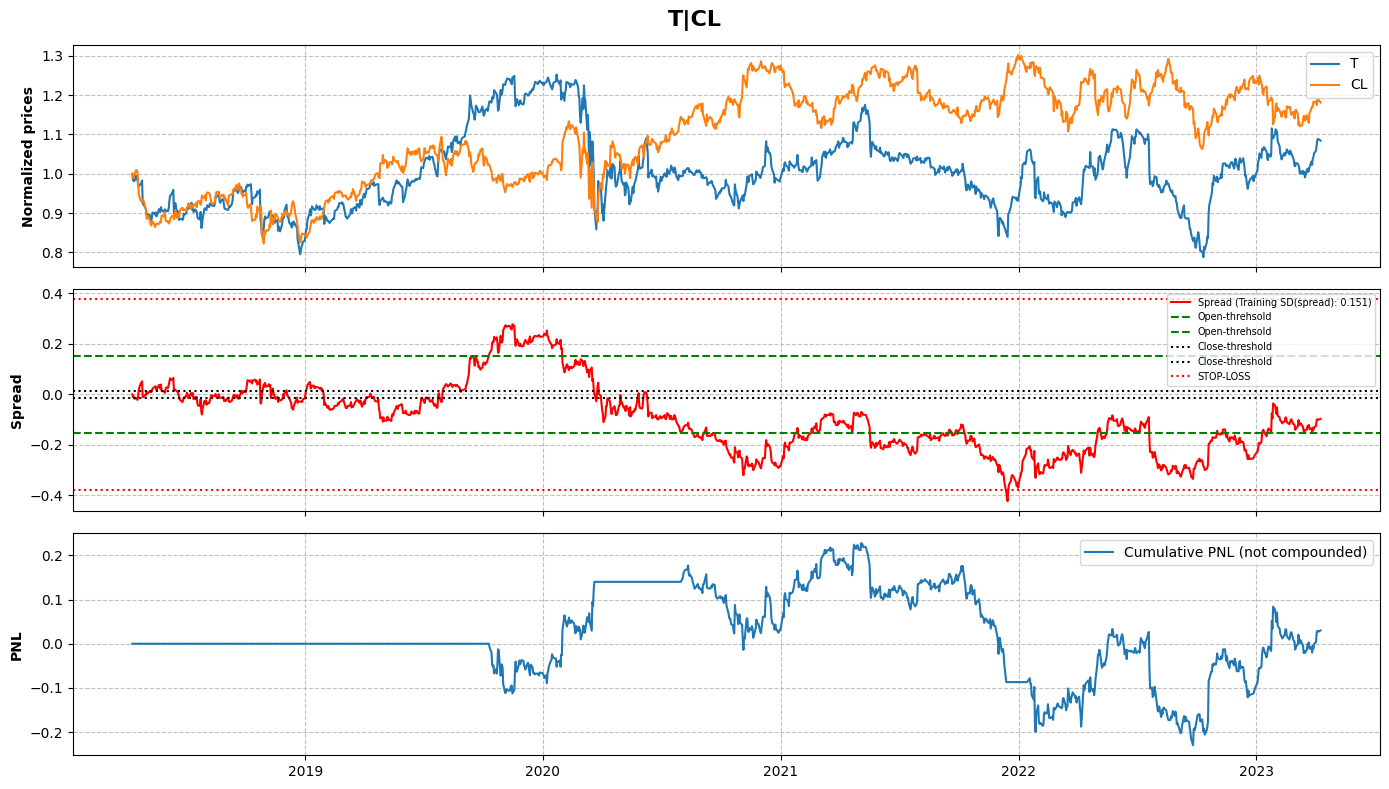

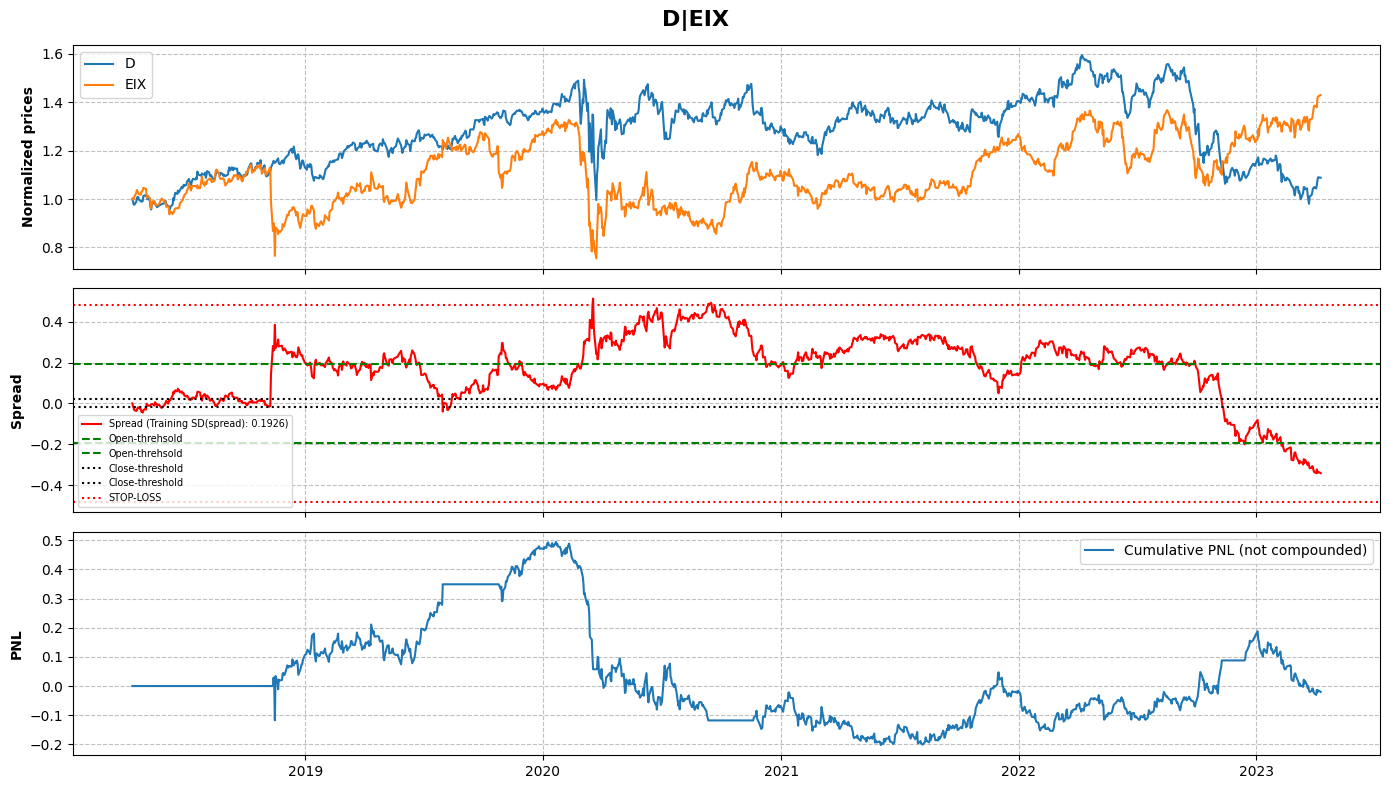

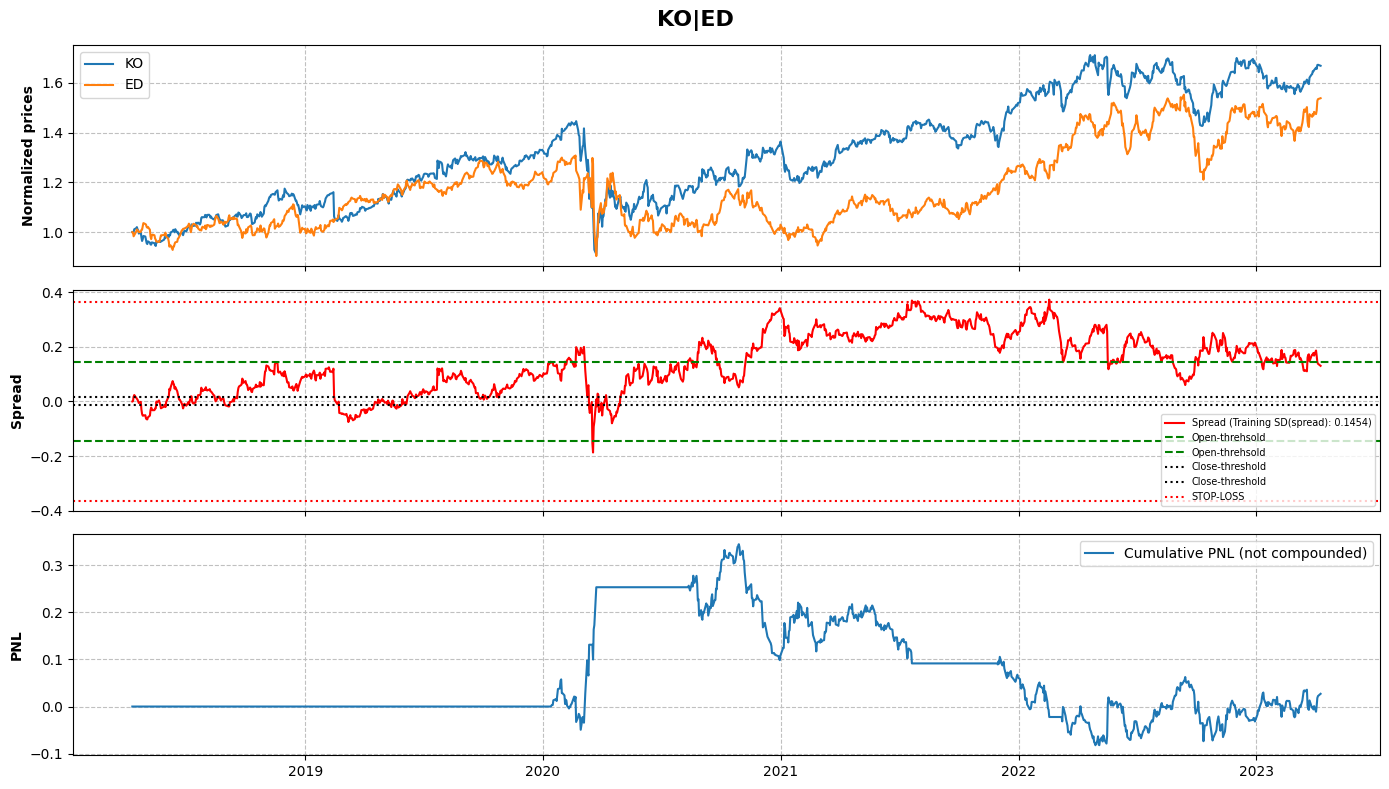

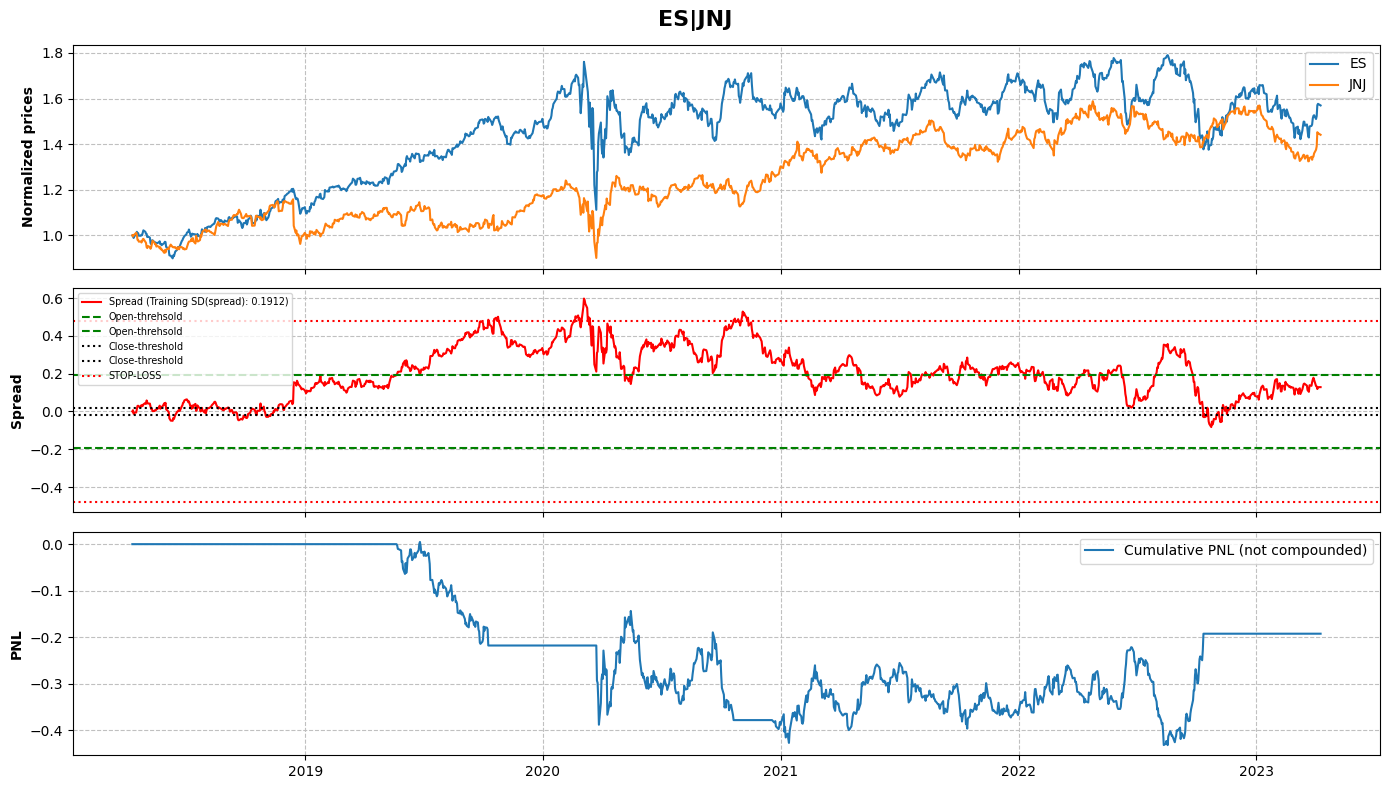

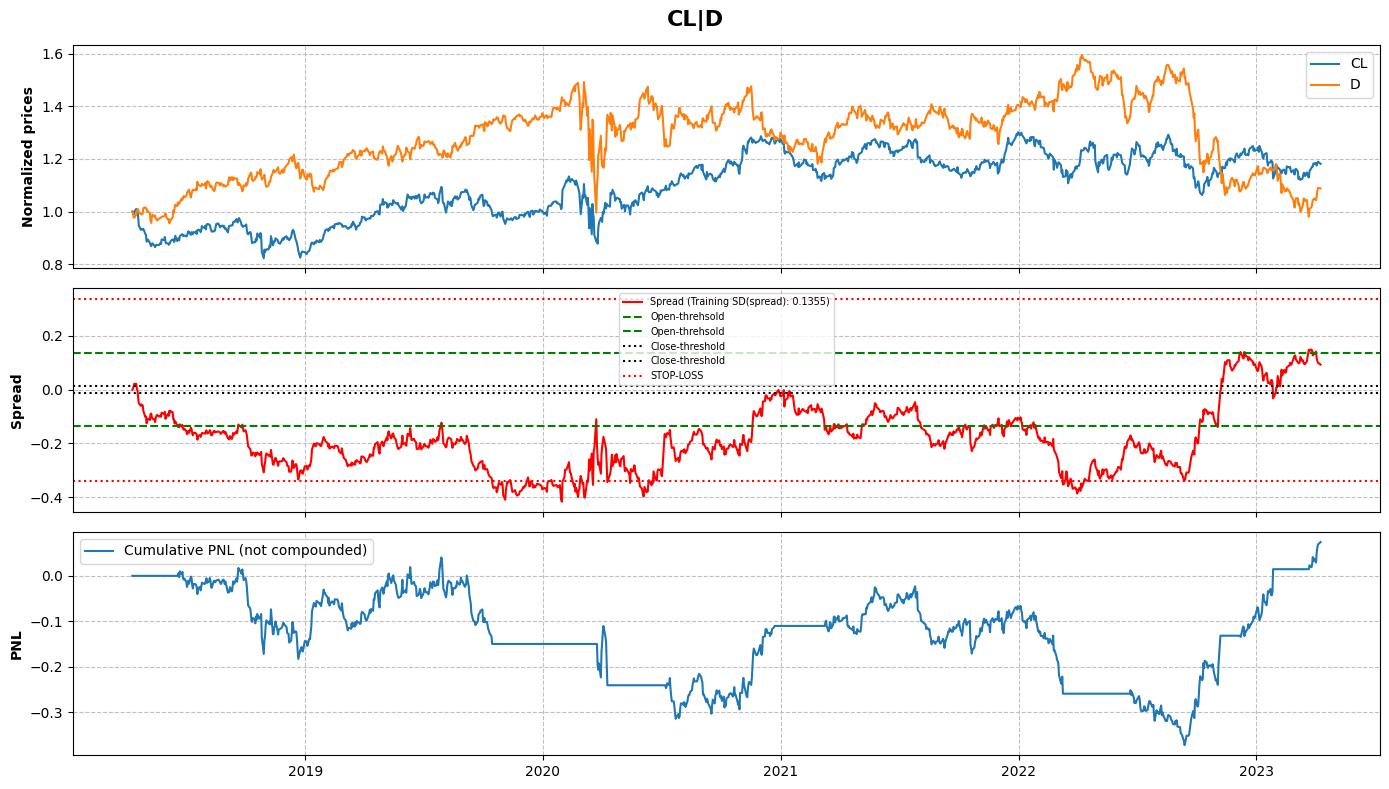

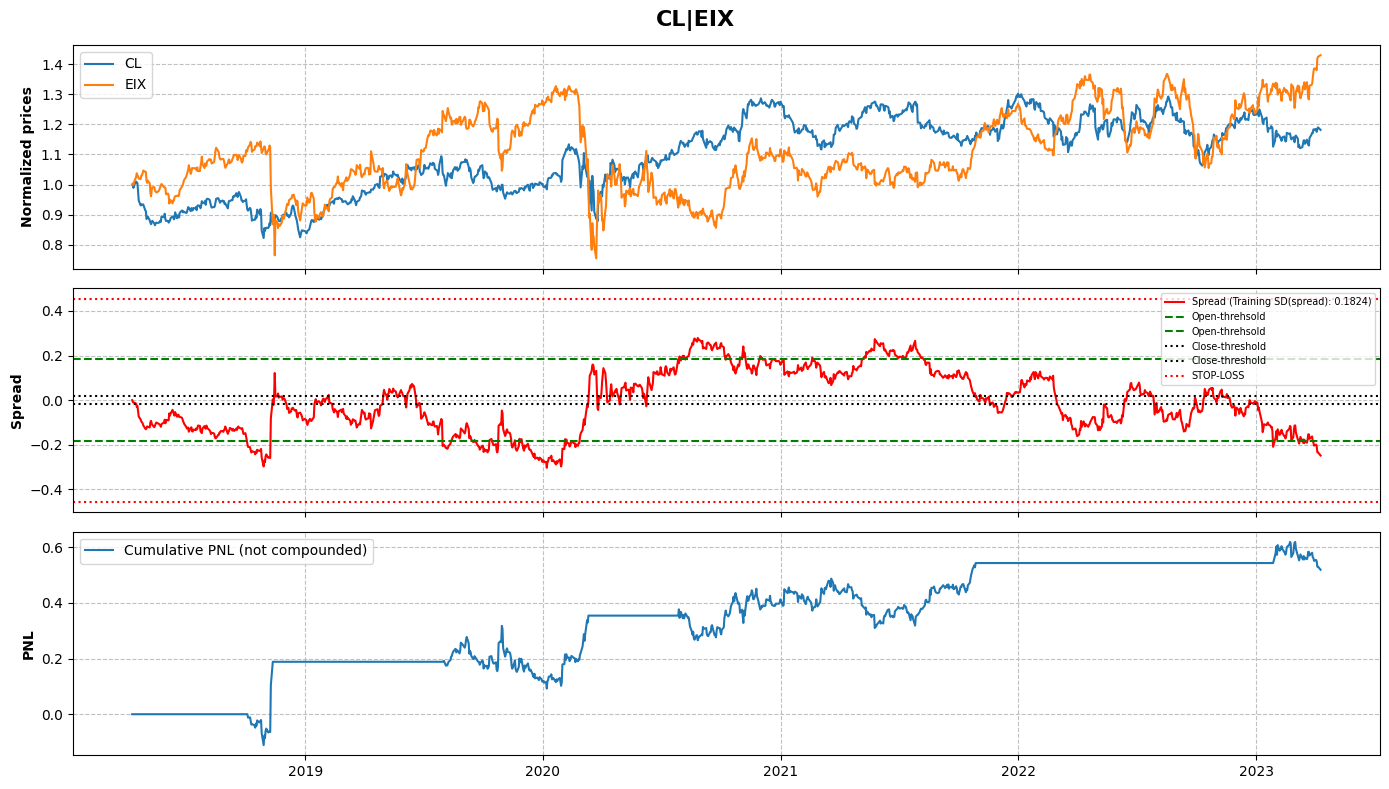

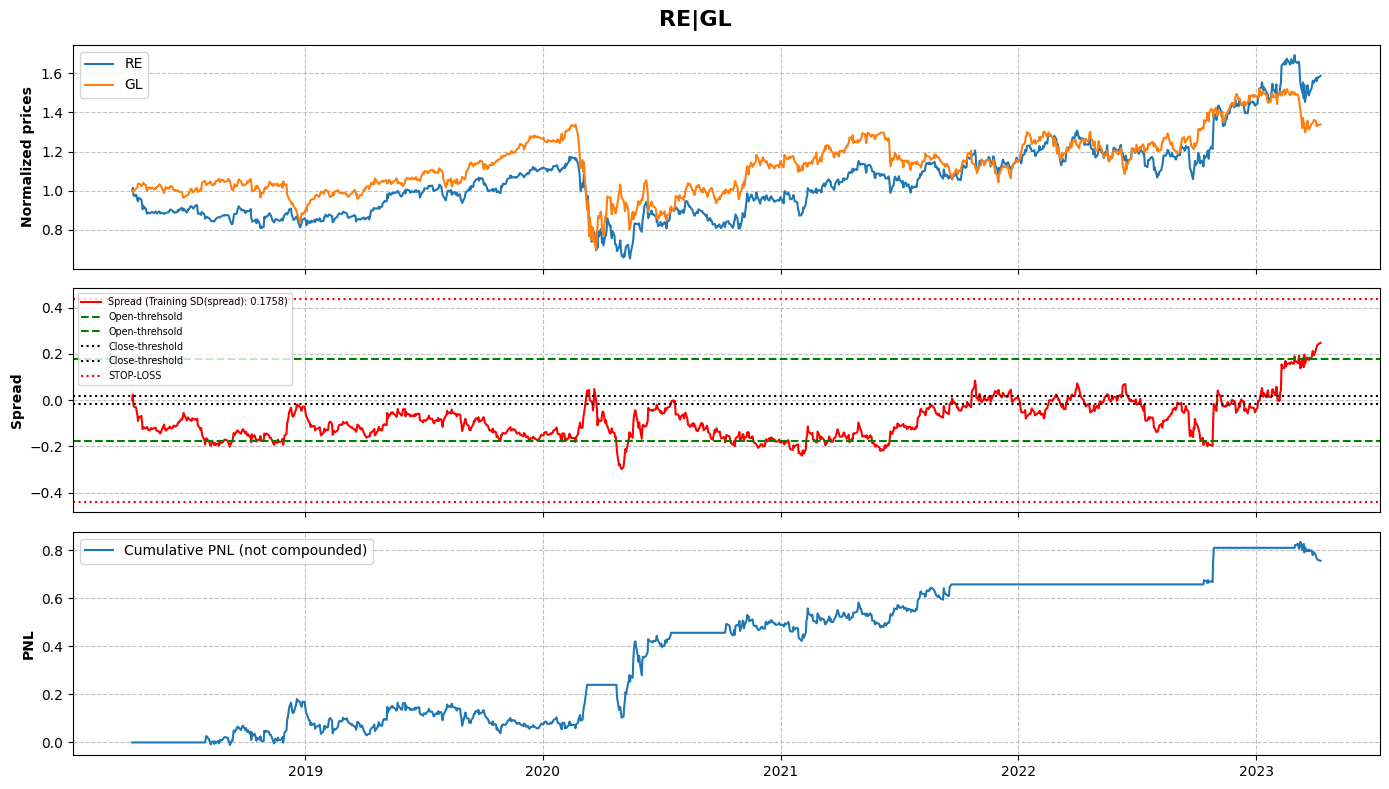

In [421]:
n_std_open = 1
n_std_close = 0.1
stop_loss = {'extra_spread_sd': 1.5, 'spread_sd_to_restart': n_std_open + 0.5}

train_data = data.iloc[:int(len(data) / 2)]
test_data = data.iloc[int(len(data) / 2):]


backtest_res = functions.backtest_strategy(
    price_df=test_data,
    tgt_pairs=top_pairs.index,
    pairs_spread_sd=top_pairs['spread_sd'].to_dict(),
    n_std_open=n_std_open,
    n_std_close=n_std_close,
    stop_loss=stop_loss
)


backtest_res['cum_pnl_total'].plot(title='STRATEGY Total Cumulative PNL', grid=True, figsize=(14, 5))
plt.show()

for pair in top_pairs.index:
    ccy_1, ccy_2 = pair.split("|")
    fig, axs = plt.subplots(nrows=3, figsize=(14, 8), sharex=True)
    fig.suptitle(pair, fontweight='bold', fontsize=16)

    tmp_norm_p = test_data[[ccy_1, ccy_2]].div(test_data[[ccy_1, ccy_2]].iloc[0])
    axs[0].plot(tmp_norm_p)
    axs[0].grid(linestyle='--', color='silver')
    axs[0].legend([ccy_1, ccy_2])
    axs[0].set_ylabel('Normalized prices', fontweight='bold')

    axs[1].plot(tmp_norm_p[ccy_1] - tmp_norm_p[ccy_2], color='red', linewidth=1.5)
    axs[1].set_ylabel('Spread', fontweight='bold')

    axs[1].axhline(top_pairs.loc[pair, "spread_sd"] * n_std_open, linestyle='--', color='green')
    axs[1].axhline(-top_pairs.loc[pair, "spread_sd"] * n_std_open, linestyle='--', color='green')
    axs[1].axhline(top_pairs.loc[pair, "spread_sd"] * n_std_close, linestyle=':', color='black')
    axs[1].axhline(-top_pairs.loc[pair, "spread_sd"] * n_std_close, linestyle=':', color='black')
    legend = [
        f'Spread (Training SD(spread): {round(top_pairs.loc[pair, "spread_sd"], 4)})',
        'Open-threhsold',
        'Open-threhsold',
        'Close-threshold',
        'Close-threshold'
    ]
    if stop_loss:
        axs[1].axhline(top_pairs.loc[pair, "spread_sd"] * (n_std_open + stop_loss['extra_spread_sd']), linestyle=':', color='red')
        axs[1].axhline(-top_pairs.loc[pair, "spread_sd"] * (n_std_open + stop_loss['extra_spread_sd']), linestyle=':', color='red')
        legend.append('STOP-LOSS')
    axs[1].legend(legend, fontsize='x-small')
    axs[1].grid(linestyle='--', color='silver')

    axs[2].plot(backtest_res['cum_pnl_breakdown'][pair])
    axs[2].grid(linestyle='--', color='silver')
    axs[2].legend(['Cumulative PNL (not compounded)'])
    axs[2].set_ylabel('PNL', fontweight='bold')

    plt.tight_layout()
    plt.plot()

    if pair == "GBPCAD|GBPNOK":
        fig.savefig('GBPCAD-GBPNOK_pair_trading_graphical.jpeg')

In [422]:
functions.get_stats_trade_duration(backtest_res['pnl_breakdown'])

{'#trade': 81,
 'avg': 107.45679012345678,
 'median': 58.0,
 'min': 3,
 'max': 496,
 'std': 115.12666662191896,
 'skew': 1.5400849722773275,
 'kurt': 1.9049680277924308}

## STEP-ROLLING-APPROACH

In [398]:
ray.shutdown()

start = perf_counter()
res = functions.backtest_strategy_with_step_rolling_approach(
    price_df=data,
    train_period=252 * 7,  # 7y
    test_period=252 * 3,   # 3y
    tv_quantile_threshold=0.1,
    coint_threshold=0.075,
    max_asset_in_portfolio=10,
    n_tv_to_open=1.5,
    n_tv_to_close=0.2,
    stop_loss=None,
    view_ram_usage=False,
    partial_return=False,
    verbose=True
)
print(f'Elapsed time: {perf_counter() - start}')

0|Testing period: FROM 2022-07-04 20:00:00 TO 2022-08-01 21:00:00
... Training


2023-04-11 13:32:26,497	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=14740) 7| Computing: USDEUR|USDCHF
(calc_x pid=26028) 6| Computing: USDEUR|USDSEK
(calc_x pid=31004) 2| Computing: USDEUR|USDAUD
(calc_x pid=16580) 3| Computing: USDEUR|USDNZD
(calc_x pid=14484) 4| Computing: USDEUR|USDCAD
(calc_x pid=27604) 5| Computing: USDEUR|USDNOK
(calc_x pid=21744) 0| Computing: USDEUR|USDGBP
(calc_x pid=26028) 10| Computing: USDEUR|EURAUD
(calc_x pid=31004) 8| Computing: USDEUR|EURGBP
(calc_x pid=16580) 12| Computing: USDEUR|EURCAD
(calc_x pid=14484) 11| Computing: USDEUR|EURNZD
(calc_x pid=21744) 9| Computing: USDEUR|EURJPY
(calc_x pid=14740) 13| Computing: USDEUR|EURNOK
(calc_x pid=27604) 14| Computing: USDEUR|EURSEK
(calc_x pid=26028) 16| Computing: USDEUR|GBPJPY
(calc_x pid=31004) 17| Computing: USDEUR|GBPAUD
(calc_x pid=16580) 19| Computing: USDEUR|GBPCAD
(calc_x pid=14484) 18| Computing: USDEUR|GBPNZD
(calc_x pid=21744) 15| Computing: USDEUR|EURCHF
(calc_x pid=14740) 20| Computing: USDEUR|GBPNOK
(calc_x pid=30692) 1| Computing: USDEUR|USDJPY
(c

2023-04-11 13:33:28,129	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=36092) 5| Computing: USDEUR|USDNOK
(calc_x pid=36428) 4| Computing: USDEUR|USDCAD
(calc_x pid=32048) 3| Computing: USDEUR|USDNZD
(calc_x pid=36796) 0| Computing: USDEUR|USDGBP
(calc_x pid=14016) 7| Computing: USDEUR|USDCHF
(calc_x pid=28596) 1| Computing: USDEUR|USDJPY
(calc_x pid=36428) 10| Computing: USDEUR|EURAUD
(calc_x pid=32048) 8| Computing: USDEUR|EURGBP
(calc_x pid=36796) 9| Computing: USDEUR|EURJPY
(calc_x pid=36092) 11| Computing: USDEUR|EURNZD
(calc_x pid=14016) 13| Computing: USDEUR|EURNOK
(calc_x pid=35780) 2| Computing: USDEUR|USDAUD
(calc_x pid=28596) 12| Computing: USDEUR|EURCAD
(calc_x pid=32048) 14| Computing: USDEUR|EURSEK
(calc_x pid=36796) 15| Computing: USDEUR|EURCHF
(calc_x pid=36092) 17| Computing: USDEUR|GBPAUD
(calc_x pid=36428) 16| Computing: USDEUR|GBPJPY
(calc_x pid=14016) 20| Computing: USDEUR|GBPNOK
(calc_x pid=35780) 19| Computing: USDEUR|GBPCAD
(calc_x pid=28596) 18| Computing: USDEUR|GBPNZD
(calc_x pid=36428) 23| Computing: USDEUR|JPYAUD
(

2023-04-11 13:34:22,347	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=29644) 4| Computing: USDEUR|USDCAD
(calc_x pid=29800) 5| Computing: USDEUR|USDNOK
(calc_x pid=27956) 3| Computing: USDEUR|USDNZD
(calc_x pid=19208) 1| Computing: USDEUR|USDJPY
(calc_x pid=17536) 2| Computing: USDEUR|USDAUD
(calc_x pid=34320) 0| Computing: USDEUR|USDGBP
(calc_x pid=31004) 6| Computing: USDEUR|USDSEK
(calc_x pid=29644) 8| Computing: USDEUR|EURGBP
(calc_x pid=27956) 11| Computing: USDEUR|EURNZD
(calc_x pid=19208) 10| Computing: USDEUR|EURAUD
(calc_x pid=29800) 9| Computing: USDEUR|EURJPY
(calc_x pid=34320) 12| Computing: USDEUR|EURCAD
(calc_x pid=31004) 13| Computing: USDEUR|EURNOK
(calc_x pid=29644) 15| Computing: USDEUR|EURCHF
(calc_x pid=17536) 14| Computing: USDEUR|EURSEK
(calc_x pid=27956) 18| Computing: USDEUR|GBPNZD
(calc_x pid=19208) 17| Computing: USDEUR|GBPAUD
(calc_x pid=16180) 7| Computing: USDEUR|USDCHF
(calc_x pid=29800) 16| Computing: USDEUR|GBPJPY
(calc_x pid=34320) 19| Computing: USDEUR|GBPCAD
(calc_x pid=31004) 20| Computing: USDEUR|GBPNOK
(c

2023-04-11 13:35:19,719	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=32956) 3| Computing: USDEUR|USDNZD
(calc_x pid=35228) 1| Computing: USDEUR|USDJPY
(calc_x pid=5276) 0| Computing: USDEUR|USDGBP
(calc_x pid=24728) 4| Computing: USDEUR|USDCAD
(calc_x pid=35892) 2| Computing: USDEUR|USDAUD
(calc_x pid=35228) 8| Computing: USDEUR|EURGBP
(calc_x pid=24728) 11| Computing: USDEUR|EURNZD
(calc_x pid=32956) 9| Computing: USDEUR|EURJPY
(calc_x pid=5276) 10| Computing: USDEUR|EURAUD
(calc_x pid=34040) 6| Computing: USDEUR|USDSEK
(calc_x pid=35892) 12| Computing: USDEUR|EURCAD
(calc_x pid=35228) 13| Computing: USDEUR|EURNOK
(calc_x pid=24728) 16| Computing: USDEUR|GBPJPY
(calc_x pid=32956) 14| Computing: USDEUR|EURSEK
(calc_x pid=5276) 15| Computing: USDEUR|EURCHF
(calc_x pid=35892) 17| Computing: USDEUR|GBPAUD
(calc_x pid=34040) 18| Computing: USDEUR|GBPNZD
(calc_x pid=7092) 5| Computing: USDEUR|USDNOK
(calc_x pid=35228) 19| Computing: USDEUR|GBPCAD
(calc_x pid=24728) 22| Computing: USDEUR|GBPCHF
(calc_x pid=32956) 20| Computing: USDEUR|GBPNOK
(calc

2023-04-11 13:36:17,846	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=28600) 6| Computing: USDEUR|USDSEK
(calc_x pid=30032) 5| Computing: USDEUR|USDNOK
(calc_x pid=17132) 2| Computing: USDEUR|USDAUD
(calc_x pid=1908) 0| Computing: USDEUR|USDGBP
(calc_x pid=24064) 1| Computing: USDEUR|USDJPY
(calc_x pid=31536) 7| Computing: USDEUR|USDCHF
(calc_x pid=28600) 9| Computing: USDEUR|EURJPY
(calc_x pid=30032) 8| Computing: USDEUR|EURGBP
(calc_x pid=17132) 10| Computing: USDEUR|EURAUD
(calc_x pid=29976) 3| Computing: USDEUR|USDNZD
(calc_x pid=1908) 12| Computing: USDEUR|EURCAD
(calc_x pid=24064) 11| Computing: USDEUR|EURNZD
(calc_x pid=31536) 13| Computing: USDEUR|EURNOK
(calc_x pid=34328) 4| Computing: USDEUR|USDCAD
(calc_x pid=31536) 20| Computing: USDEUR|GBPNOK
(calc_x pid=28600) 15| Computing: USDEUR|EURCHF
(calc_x pid=30032) 16| Computing: USDEUR|GBPJPY
(calc_x pid=34328) 21| Computing: USDEUR|GBPSEK
(calc_x pid=17132) 17| Computing: USDEUR|GBPAUD
(calc_x pid=29976) 14| Computing: USDEUR|EURSEK
(calc_x pid=1908) 18| Computing: USDEUR|GBPNZD
(calc

2023-04-11 13:37:12,288	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=30040) 3| Computing: USDEUR|USDNZD
(calc_x pid=3120) 4| Computing: USDEUR|USDCAD
(calc_x pid=25588) 0| Computing: USDEUR|USDGBP
(calc_x pid=26632) 5| Computing: USDEUR|USDNOK
(calc_x pid=30040) 8| Computing: USDEUR|EURGBP
(calc_x pid=17844) 2| Computing: USDEUR|USDAUD
(calc_x pid=26632) 11| Computing: USDEUR|EURNZD
(calc_x pid=3120) 10| Computing: USDEUR|EURAUD
(calc_x pid=25588) 9| Computing: USDEUR|EURJPY
(calc_x pid=12224) 7| Computing: USDEUR|USDCHF
(calc_x pid=30040) 13| Computing: USDEUR|EURNOK
(calc_x pid=17844) 12| Computing: USDEUR|EURCAD
(calc_x pid=3120) 15| Computing: USDEUR|EURCHF
(calc_x pid=25588) 14| Computing: USDEUR|EURSEK
(calc_x pid=17844) 18| Computing: USDEUR|GBPNZD
(calc_x pid=26632) 16| Computing: USDEUR|GBPJPY
(calc_x pid=12224) 17| Computing: USDEUR|GBPAUD
(calc_x pid=30040) 19| Computing: USDEUR|GBPCAD
(calc_x pid=25588) 20| Computing: USDEUR|GBPNOK
(calc_x pid=31048) 1| Computing: USDEUR|USDJPY
(calc_x pid=33540) 6| Computing: USDEUR|USDSEK
(calc

2023-04-11 13:38:13,255	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=21468) 6| Computing: USDEUR|USDSEK
(calc_x pid=22912) 2| Computing: USDEUR|USDAUD
(calc_x pid=33904) 1| Computing: USDEUR|USDJPY
(calc_x pid=31108) 3| Computing: USDEUR|USDNZD
(calc_x pid=31324) 0| Computing: USDEUR|USDGBP
(calc_x pid=33244) 7| Computing: USDEUR|USDCHF
(calc_x pid=21468) 11| Computing: USDEUR|EURNZD
(calc_x pid=2720) 4| Computing: USDEUR|USDCAD
(calc_x pid=22912) 10| Computing: USDEUR|EURAUD
(calc_x pid=33904) 9| Computing: USDEUR|EURJPY
(calc_x pid=31108) 8| Computing: USDEUR|EURGBP
(calc_x pid=2720) 14| Computing: USDEUR|EURSEK
(calc_x pid=22912) 15| Computing: USDEUR|EURCHF
(calc_x pid=33904) 16| Computing: USDEUR|GBPJPY
(calc_x pid=31108) 13| Computing: USDEUR|EURNOK
(calc_x pid=31324) 12| Computing: USDEUR|EURCAD
(calc_x pid=33244) 17| Computing: USDEUR|GBPAUD
(calc_x pid=21468) 18| Computing: USDEUR|GBPNZD
(calc_x pid=26864) 5| Computing: USDEUR|USDNOK
(calc_x pid=31324) 19| Computing: USDEUR|GBPCAD
(calc_x pid=33244) 24| Computing: USDEUR|JPYNZD
(cal

2023-04-11 13:39:04,640	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=1184) 3| Computing: USDEUR|USDNZD
(calc_x pid=11724) 4| Computing: USDEUR|USDCAD
(calc_x pid=9956) 6| Computing: USDEUR|USDSEK
(calc_x pid=23716) 1| Computing: USDEUR|USDJPY
(calc_x pid=30316) 2| Computing: USDEUR|USDAUD
(calc_x pid=9388) 0| Computing: USDEUR|USDGBP
(calc_x pid=24636) 7| Computing: USDEUR|USDCHF
(calc_x pid=36288) 5| Computing: USDEUR|USDNOK
(calc_x pid=1184) 8| Computing: USDEUR|EURGBP
(calc_x pid=36288) 14| Computing: USDEUR|EURSEK
(calc_x pid=11724) 10| Computing: USDEUR|EURAUD
(calc_x pid=9956) 9| Computing: USDEUR|EURJPY
(calc_x pid=30316) 13| Computing: USDEUR|EURNOK
(calc_x pid=9388) 11| Computing: USDEUR|EURNZD
(calc_x pid=24636) 15| Computing: USDEUR|EURCHF
(calc_x pid=23716) 12| Computing: USDEUR|EURCAD
(calc_x pid=24636) 22| Computing: USDEUR|GBPCHF
(calc_x pid=1184) 16| Computing: USDEUR|GBPJPY
(calc_x pid=36288) 19| Computing: USDEUR|GBPCAD
(calc_x pid=11724) 21| Computing: USDEUR|GBPSEK
(calc_x pid=9956) 17| Computing: USDEUR|GBPAUD
(calc_x pi

2023-04-11 13:39:56,487	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=36724) 4| Computing: USDEUR|USDCAD
(calc_x pid=25172) 2| Computing: USDEUR|USDAUD
(calc_x pid=34692) 0| Computing: USDEUR|USDGBP
(calc_x pid=33824) 7| Computing: USDEUR|USDCHF
(calc_x pid=36240) 3| Computing: USDEUR|USDNZD
(calc_x pid=36384) 1| Computing: USDEUR|USDJPY
(calc_x pid=28068) 5| Computing: USDEUR|USDNOK
(calc_x pid=14528) 6| Computing: USDEUR|USDSEK
(calc_x pid=36724) 11| Computing: USDEUR|EURNZD
(calc_x pid=25172) 9| Computing: USDEUR|EURJPY
(calc_x pid=36384) 13| Computing: USDEUR|EURNOK
(calc_x pid=34692) 8| Computing: USDEUR|EURGBP
(calc_x pid=33824) 10| Computing: USDEUR|EURAUD
(calc_x pid=14528) 15| Computing: USDEUR|EURCHF
(calc_x pid=28068) 14| Computing: USDEUR|EURSEK
(calc_x pid=36240) 12| Computing: USDEUR|EURCAD
(calc_x pid=14528) 23| Computing: USDEUR|JPYAUD
(calc_x pid=28068) 21| Computing: USDEUR|GBPSEK
(calc_x pid=36240) 20| Computing: USDEUR|GBPNOK
(calc_x pid=36724) 16| Computing: USDEUR|GBPJPY
(calc_x pid=25172) 19| Computing: USDEUR|GBPCAD
(c

2023-04-11 13:40:54,703	INFO worker.py:1553 -- Started a local Ray instance.


(calc_x pid=16544) 4| Computing: USDEUR|USDCAD
(calc_x pid=18024) 3| Computing: USDEUR|USDNZD
(calc_x pid=9644) 0| Computing: USDEUR|USDGBP
(calc_x pid=28496) 6| Computing: USDEUR|USDSEK
(calc_x pid=22760) 7| Computing: USDEUR|USDCHF
(calc_x pid=12860) 1| Computing: USDEUR|USDJPY
(calc_x pid=16544) 8| Computing: USDEUR|EURGBP
(calc_x pid=28496) 9| Computing: USDEUR|EURJPY
(calc_x pid=18024) 10| Computing: USDEUR|EURAUD
(calc_x pid=9644) 11| Computing: USDEUR|EURNZD
(calc_x pid=12860) 12| Computing: USDEUR|EURCAD
(calc_x pid=22760) 13| Computing: USDEUR|EURNOK
(calc_x pid=36360) 2| Computing: USDEUR|USDAUD
(calc_x pid=28496) 14| Computing: USDEUR|EURSEK
(calc_x pid=18024) 15| Computing: USDEUR|EURCHF
(calc_x pid=16544) 17| Computing: USDEUR|GBPAUD
(calc_x pid=9644) 16| Computing: USDEUR|GBPJPY
(calc_x pid=12860) 18| Computing: USDEUR|GBPNZD
(calc_x pid=22760) 19| Computing: USDEUR|GBPCAD
(calc_x pid=28496) 21| Computing: USDEUR|GBPSEK
(calc_x pid=36360) 20| Computing: USDEUR|GBPNOK
(cal

<AxesSubplot:>

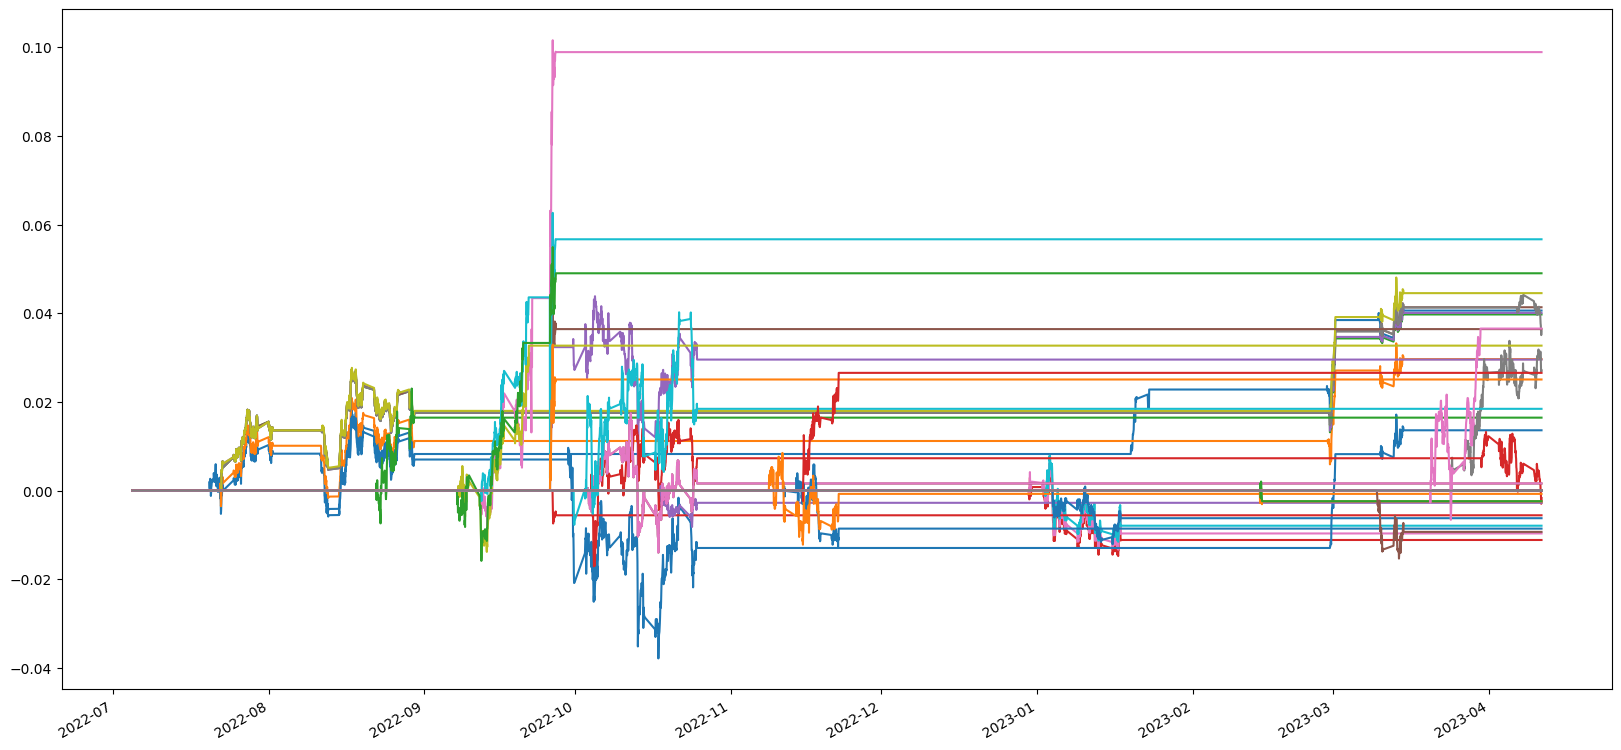

In [399]:
res[0]['cum_pnl_breakdown'].plot(figsize=(20,10), legend=None)

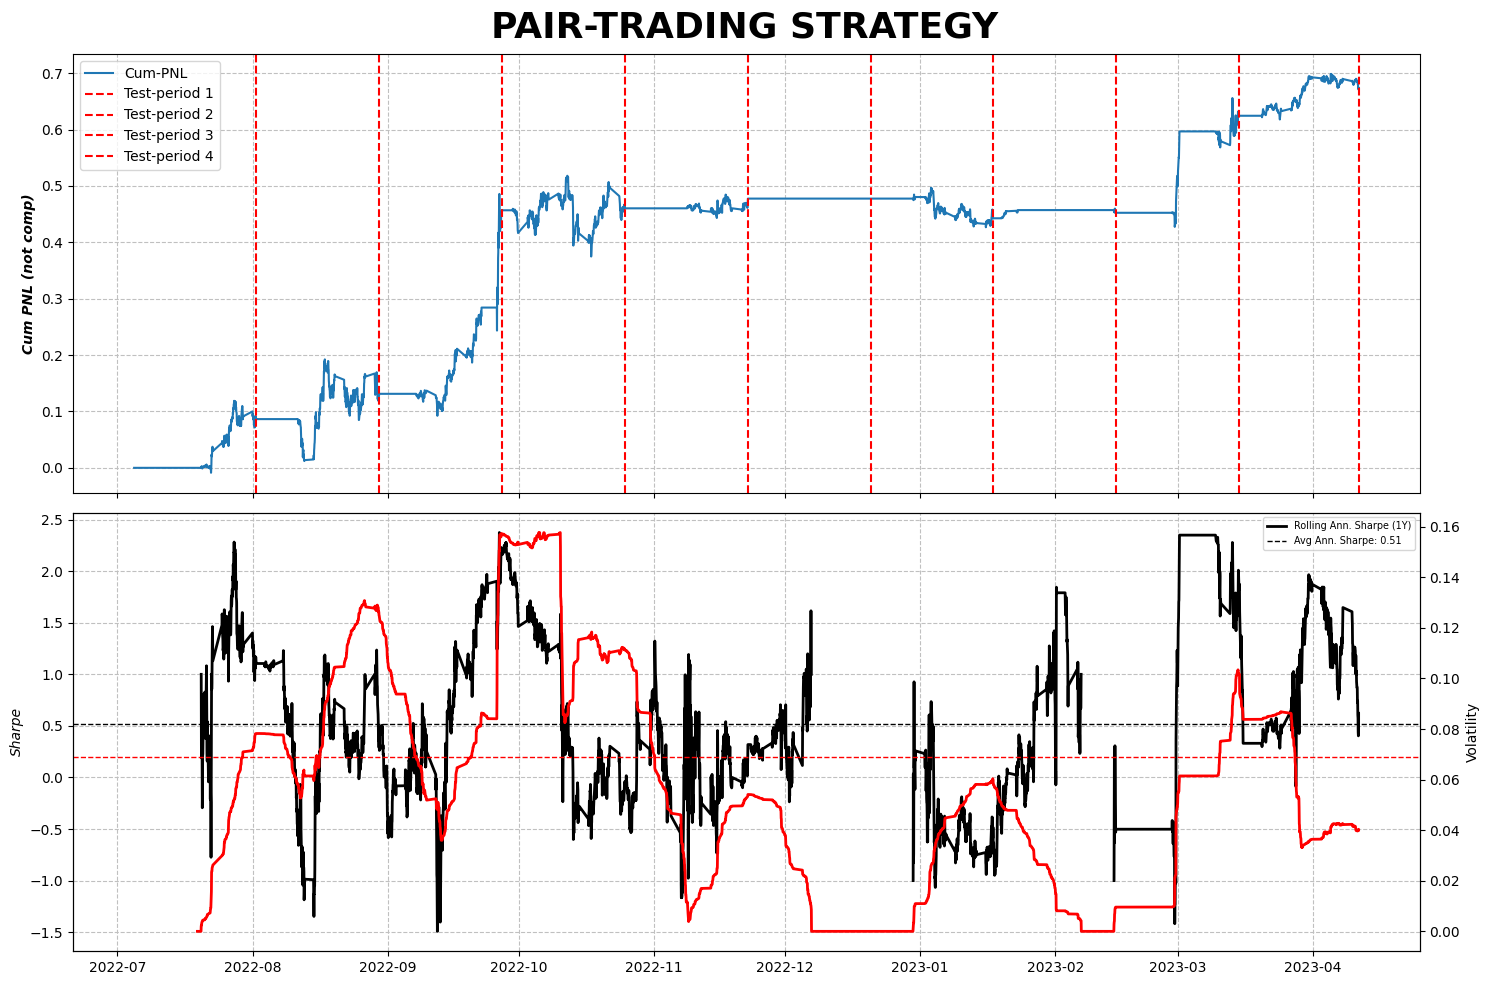

In [403]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)
fig.suptitle('PAIR-TRADING STRATEGY', fontweight='bold', fontsize=26)
axs[0].plot(res[0]['cum_pnl_total'])
for set in res[1]:
    end_test = pd.Timestamp(set['test']['end'])
    axs[0].axvline(end_test, color='red', linestyle='--')
axs[0].grid(linestyle='--', color='silver')
axs[0].set_ylabel('Cum PNL (not comp)', style='italic', fontweight='bold')
axs[0].legend(['Cum-PNL', 'Test-period 1', 'Test-period 2', 'Test-period 3', 'Test-period 4'])


rets = res[0]['pnl_total']
rolling_sharpe = rets.rolling(252).apply(lambda x: x.mean() / x.std() * np.sqrt(252))
rolling_vola = rets.rolling(252).std() * np.sqrt(252)
axs[1].plot(rolling_sharpe, color='black', linewidth=2, zorder=10)
axs[1].grid(linestyle='--', color='silver')
axs[1].set_ylabel('Sharpe', style='italic')
avg_sharpe = rets.mean() / rets.std() * np.sqrt(252)
avg_vola = rets.std() * np.sqrt(252)
axs[1].axhline(avg_sharpe, linestyle='--', color='black', linewidth=1, zorder=1)
axx = axs[1].twinx()
axx.plot(rolling_vola, color='red', linewidth=2, zorder=9)
axx.axhline(avg_vola, linestyle='--', color='red', linewidth=1, zorder=1)
axx.set_ylabel('Volatility')
axs[1].legend(['Rolling Ann. Sharpe (1Y)', f'Avg Ann. Sharpe: {round(avg_sharpe, 2)}'], fontsize='x-small')
axx.legend(['Rolling Ann. Volatility (1Y)', f'Avg Ann. Vola: {round(avg_vola * 100, 2)}%'], fontsize='x-small')

plt.tight_layout()
plt.show()

In [411]:
analyst = Analyst(strategy_rets=res[0]['pnl_total'])
strategy_stats = analyst.get_performance_analysis()
strategy_stats.to_excel("strategy_stats.xlsx")

analyst_ = Analyst(strategy_rets=backtest_res['pnl_total'])
strategy_stats_ = analyst_.get_performance_analysis()

pd.concat([strategy_stats, strategy_stats_, strategy_stats - strategy_stats_], axis=1, keys=['rolling step strat', 'static_strat', 'delta'])

rolling step strat  static_strat      delta
Total Return                        0.673820      4.805374  -4.131554
Avg Ann. Return                     0.035449      0.961838  -0.926389
Avg Ann. Volatility                 0.068865      0.897703  -0.828838
Avg Ann. Semi-Volatility            0.072391      0.711328  -0.638938
Max Drawdown                       -0.136664     -0.822721   0.686058
VaR(99%) Parametric                -0.010108     -0.131761   0.121654
VaR(99%) Not Parametric            -0.013582     -0.152730   0.139148
Daily Skewness                      1.427442      0.491340   0.936102
Daily Kurtosis                     38.450384      8.069987  30.380397
Ann. Sharpe                         0.514767      1.071444  -0.556676
Ann. Sortino                        0.489697      1.352172  -0.862475
Best Day                            0.076425      0.412941  -0.336516
Worst Day                          -0.040791     -0.337294   0.296503